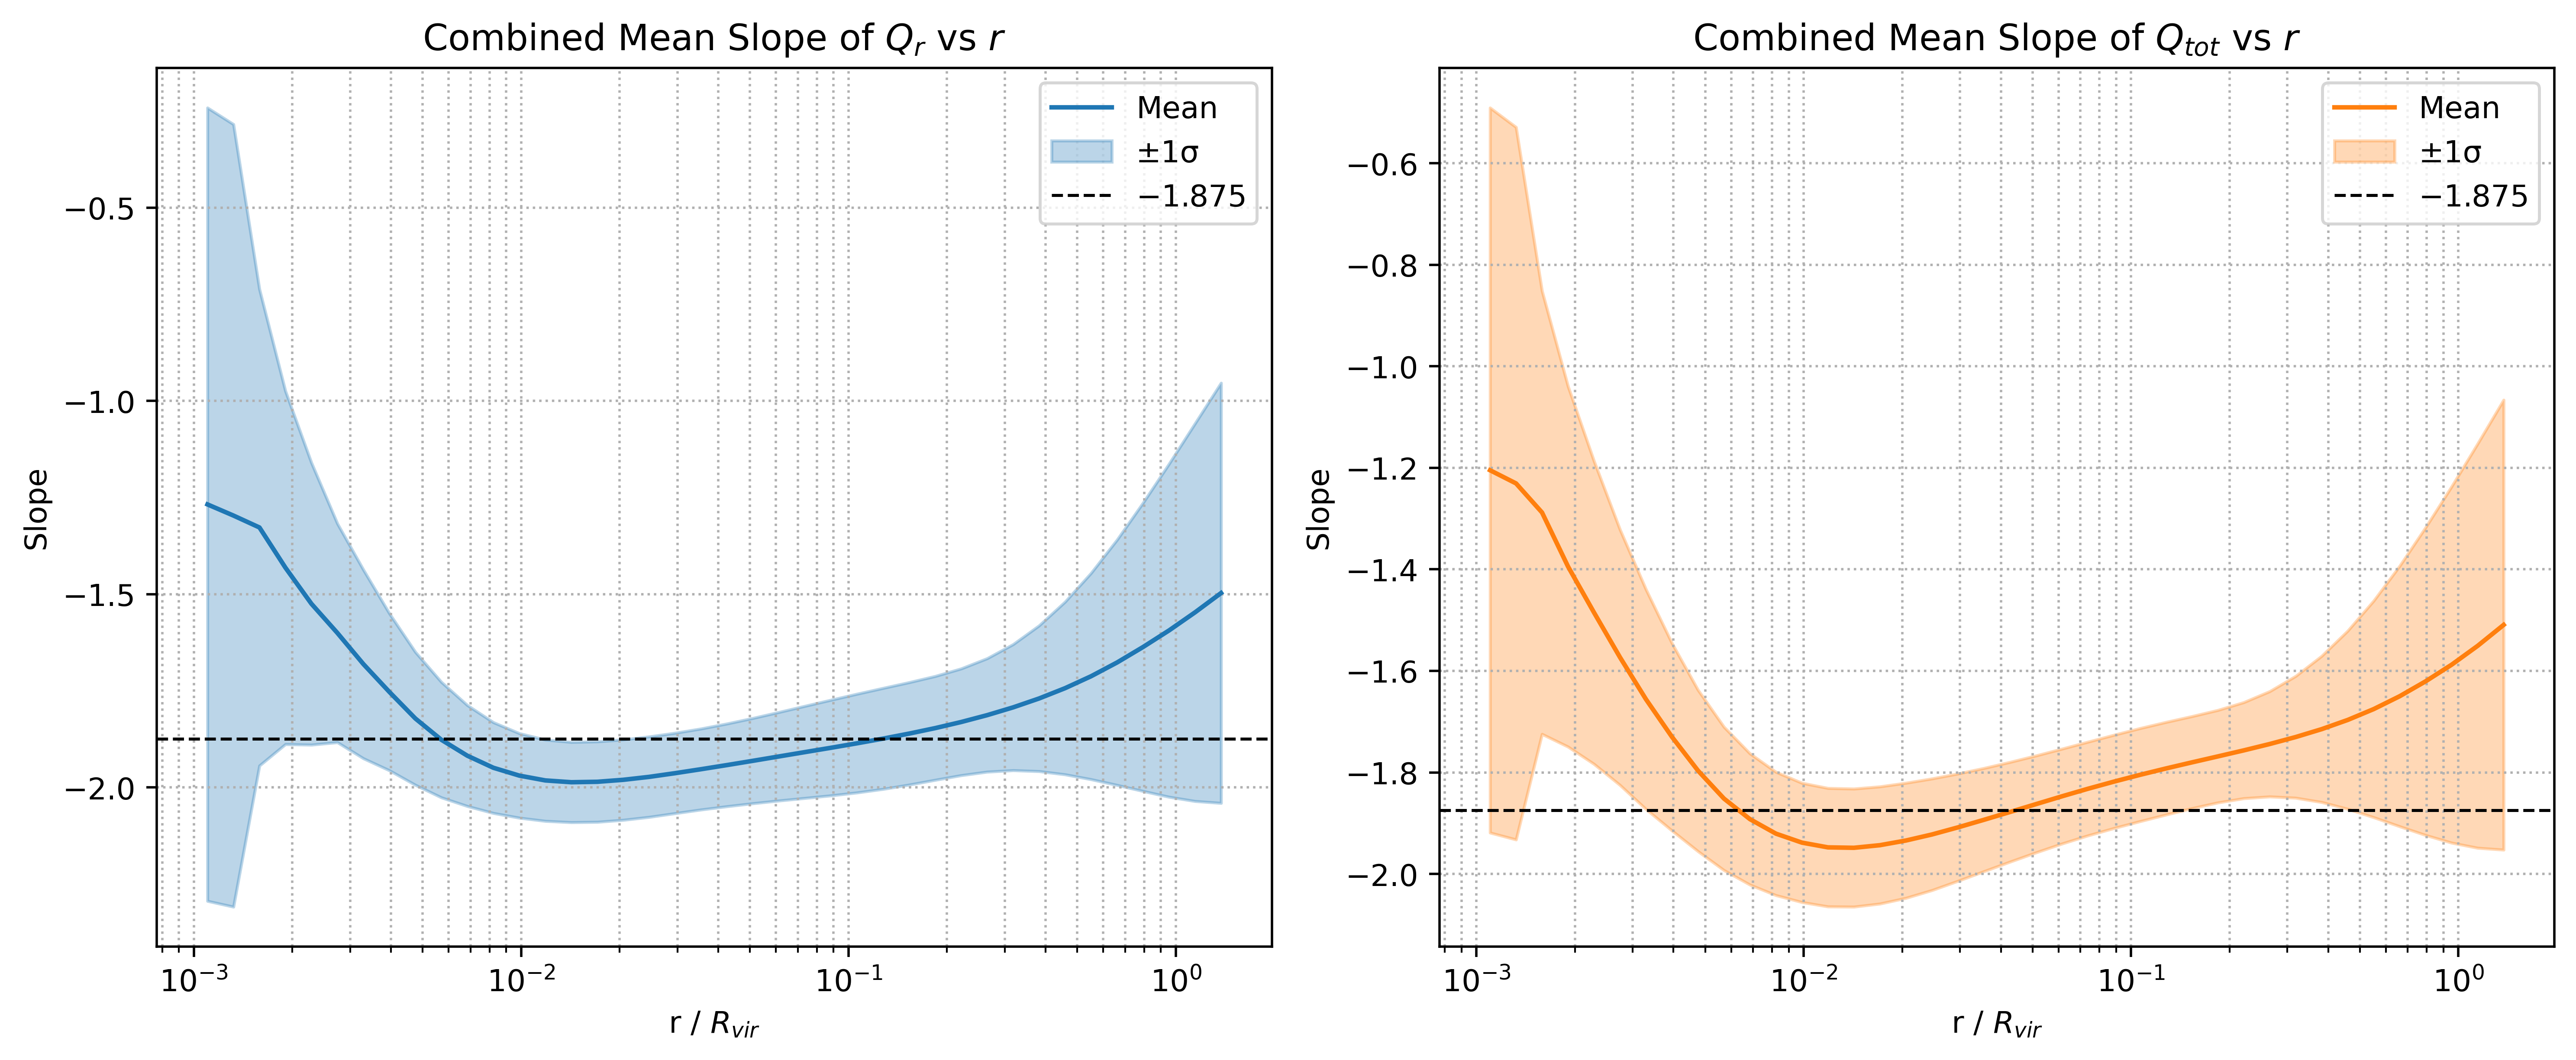

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_mean_ppsd_slope_vs_radius(base_dir, suite_names):
    slope_r_all, slope_tot_all, r_grid_ref = [], [], None

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        files = sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")])

        for f in files:
            df = pd.read_csv(os.path.join(slope_dir, f))
            r = df["r_scaled"].values
            s_Qr = df["slope_Q_r"].values
            s_Qtot = df["slope_Q_tot"].values

            if not np.all(np.isfinite(r)) or not np.all(np.isfinite(s_Qr)) or not np.all(np.isfinite(s_Qtot)):
                continue

            if r_grid_ref is None:
                r_grid_ref = r
            if not np.allclose(r, r_grid_ref, rtol=1e-4, atol=1e-6):
                continue  # skip if r_grid inconsistent

            slope_r_all.append(s_Qr)
            slope_tot_all.append(s_Qtot)

    slope_r_all = np.array(slope_r_all)
    slope_tot_all = np.array(slope_tot_all)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=500)
    ax_r, ax_tot = axes

    def plot_mean_with_error(ax, r, data, title, color):
        mean = np.nanmean(data, axis=0)
        std = np.nanstd(data, axis=0)
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$")
        ax.set_ylabel("Slope")
        ax.set_title(title)
        ax.plot(r, mean, color=color, label="Mean")
        ax.fill_between(r, mean - std, mean + std, color=color, alpha=0.3, label="±1σ")
        ax.axhline(-1.875, color="black", ls="--", lw=1, label="$-1.875$")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    plot_mean_with_error(ax_r, r_grid_ref, slope_r_all, "Combined Mean Slope of $Q_r$ vs $r$", "tab:blue")
    plot_mean_with_error(ax_tot, r_grid_ref, slope_tot_all, "Combined Mean Slope of $Q_{tot}$ vs $r$", "tab:orange")

    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup",
          "SymphonyLCluster", "SymphonyCluster"]
plot_combined_mean_ppsd_slope_vs_radius(base_dir, suite_names)

  a = 42638711405.0297
  b = 23868716805.0266


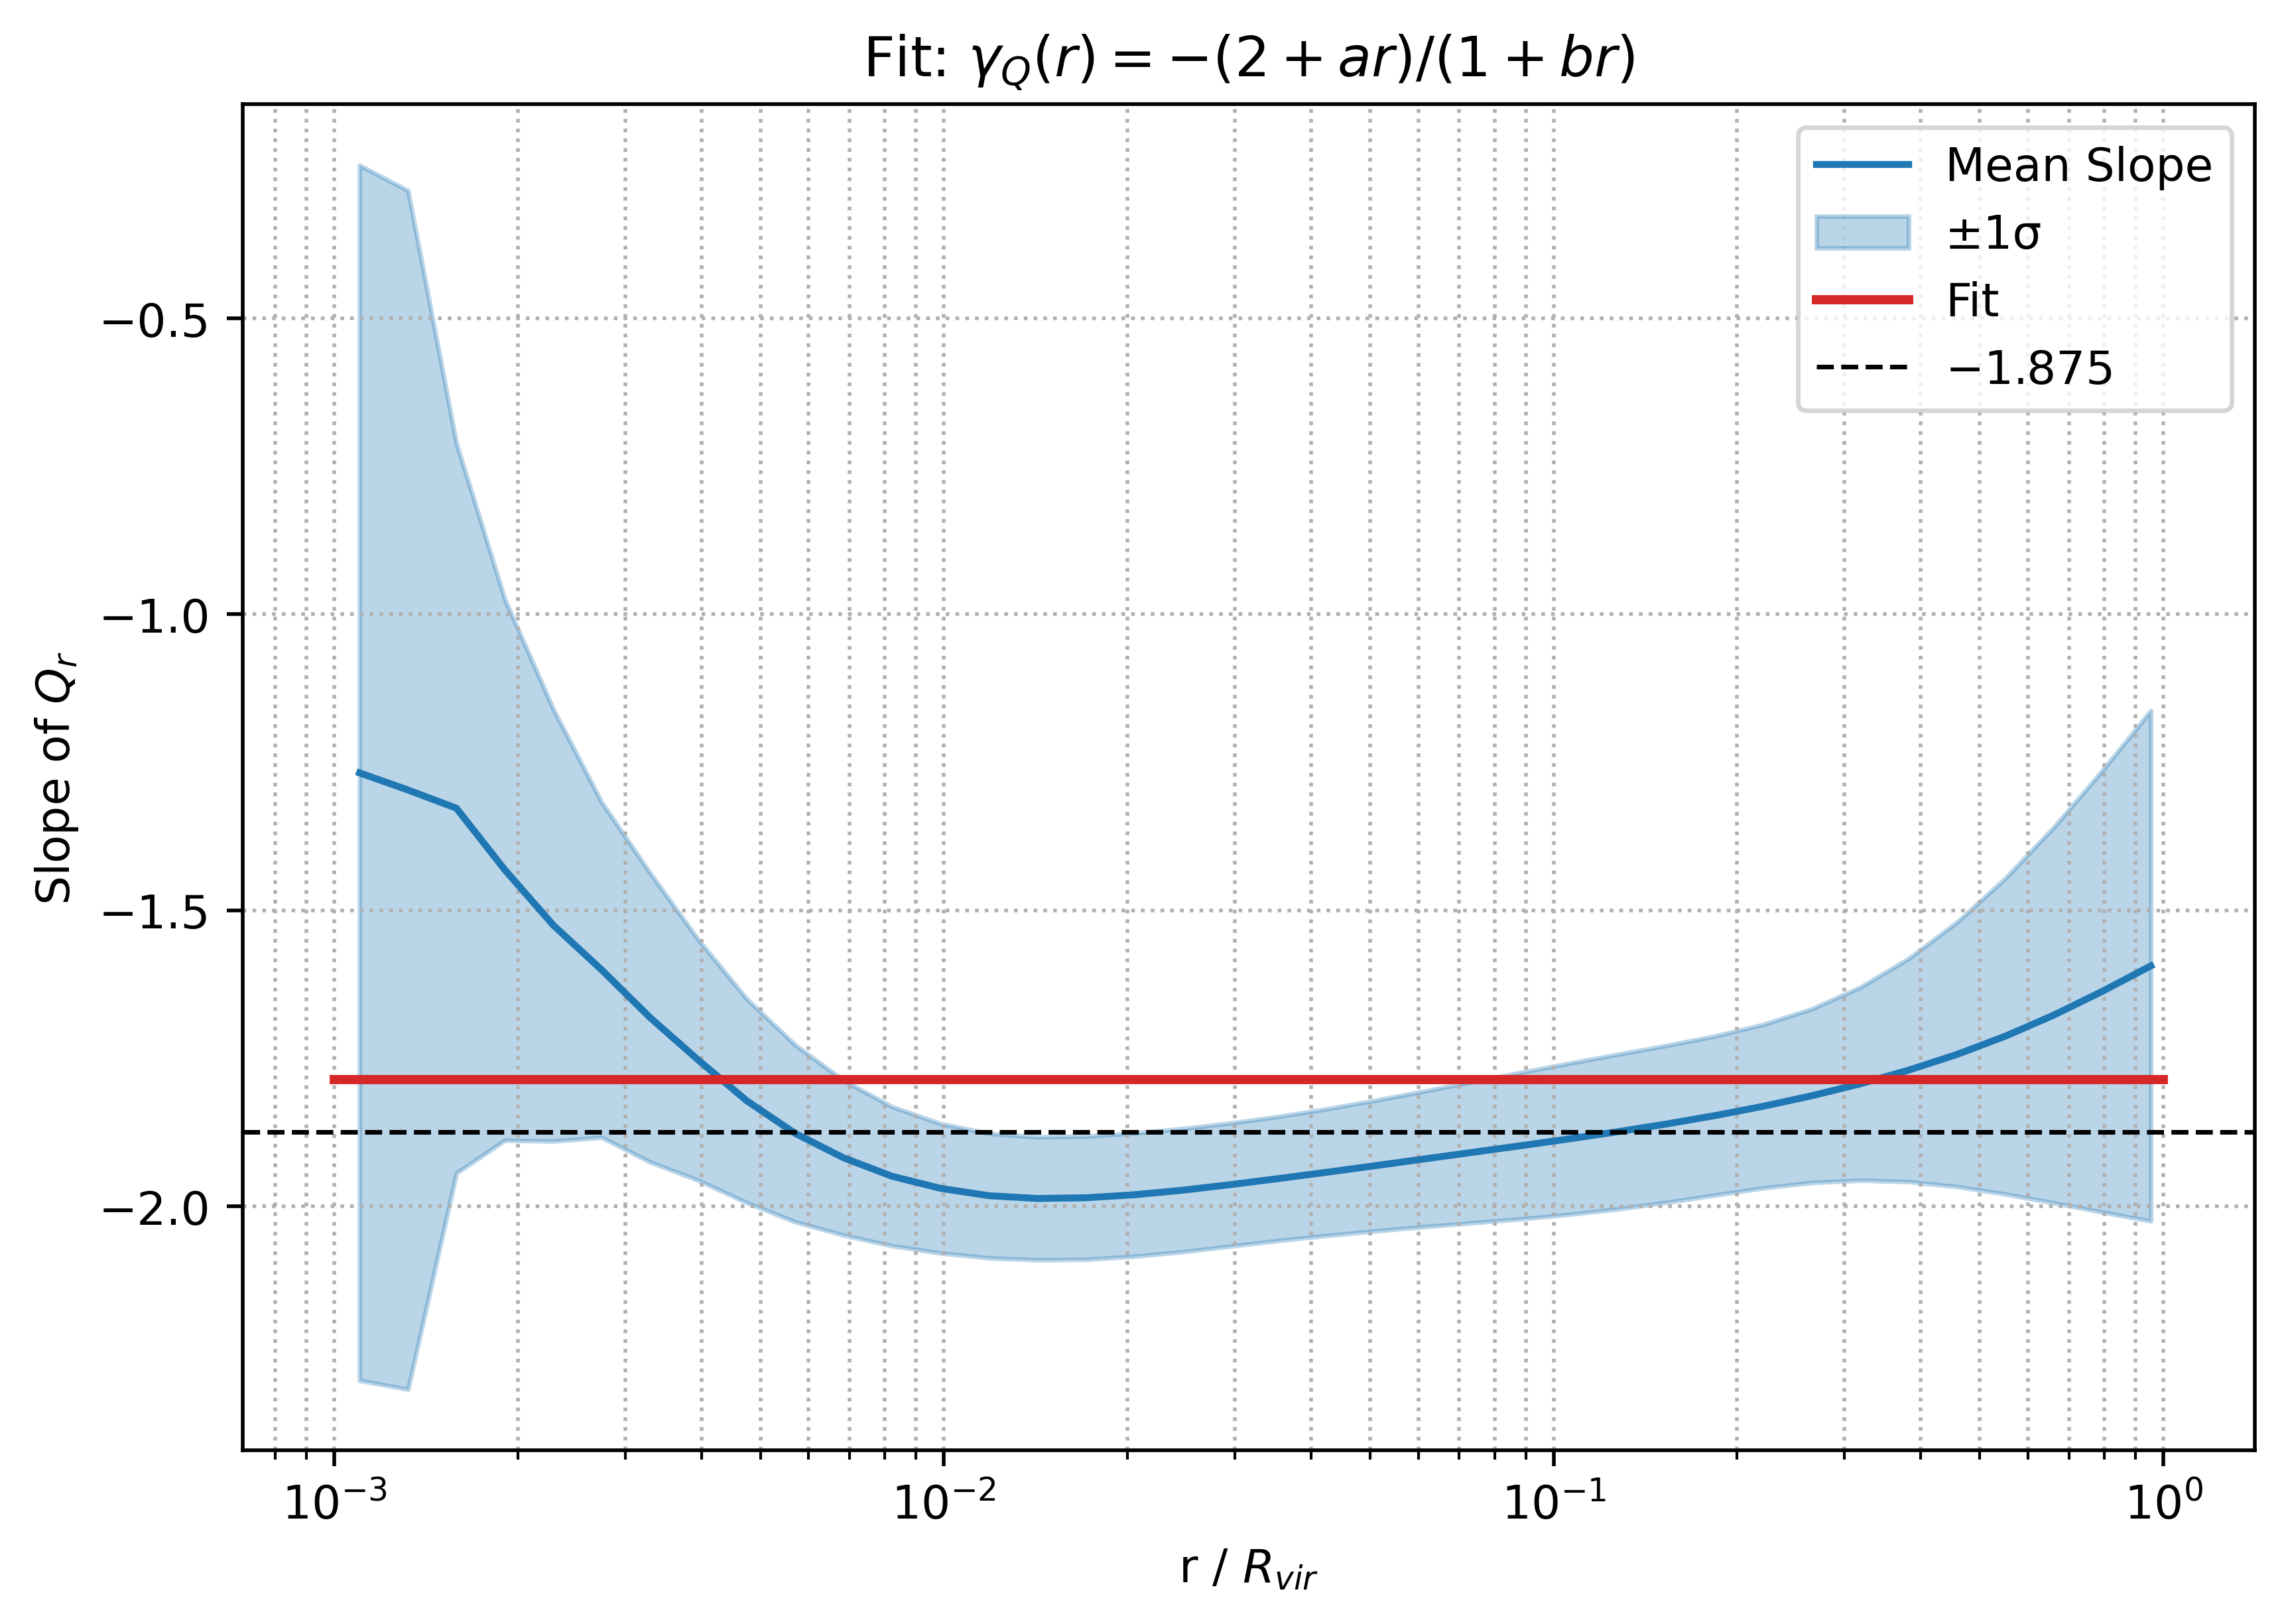

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gamma_Q_model(r, a, b):
    return -(2.5 + a * r) / (1 + b * r)

def fit_and_plot_custom_gamma_Q(base_dir, suite_names):
    slope_r_all, r_grid_ref = [], None

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        files = sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")])

        for f in files:
            df = pd.read_csv(os.path.join(slope_dir, f))
            r = df["r_scaled"].values
            s_Qr = df["slope_Q_r"].values

            if not np.all(np.isfinite(r)) or not np.all(np.isfinite(s_Qr)):
                continue

            if r_grid_ref is None:
                r_grid_ref = r
            if not np.allclose(r, r_grid_ref, rtol=1e-4, atol=1e-6):
                continue

            slope_r_all.append(s_Qr)

    slope_r_all = np.array(slope_r_all)
    r = r_grid_ref
    mean_slope = np.nanmean(slope_r_all, axis=0)
    std_slope = np.nanstd(slope_r_all, axis=0)

    mask = (r >= 1e-3) & (r <= 1.0) & np.isfinite(mean_slope)
    r_fit = r[mask]
    y_fit = mean_slope[mask]
    std_fit = std_slope[mask]

    # Fit the new model
    popt, pcov = curve_fit(gamma_Q_model, r_fit, y_fit, p0=[0, 0])
    a_fit, b_fit = popt

    print(f"  a = {a_fit:.4f}")
    print(f"  b = {b_fit:.4f}")

    # Plotting
    plt.figure(figsize=(7, 5), dpi=500)
    plt.xscale("log")
    plt.xlabel("r / $R_{{vir}}$")
    plt.ylabel("Slope of $Q_r$")
    plt.title("Fit: $\\gamma_Q(r) = -(2 + a r)/(1 + b r)$")
    plt.plot(r_fit, y_fit, color="tab:blue", label="Mean Slope")
    plt.fill_between(r_fit, y_fit - std_fit, y_fit + std_fit, color="tab:blue", alpha=0.3, label="±1σ")

    r_dense = np.logspace(np.log10(1e-3), np.log10(1.0), 500)
    fitted_curve = gamma_Q_model(r_dense, *popt)
    plt.plot(r_dense, fitted_curve, color="tab:red", lw=2, ls="-", label="Fit")

    plt.axhline(-1.875, color="black", ls="--", lw=1, label="$-1.875$")
    plt.grid(True, which="both", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
fit_and_plot_custom_gamma_Q(base_dir, suite_names)

📊 Global RMSE Statistics:
  Total halos      = 236
  Mean RMSE        = 0.0629
  Std. dev of RMSE = 0.0439
  RMSE < 0.05      = 111 halos (47.0%)
  RMSE > 0.10      = 32 halos (13.6%)


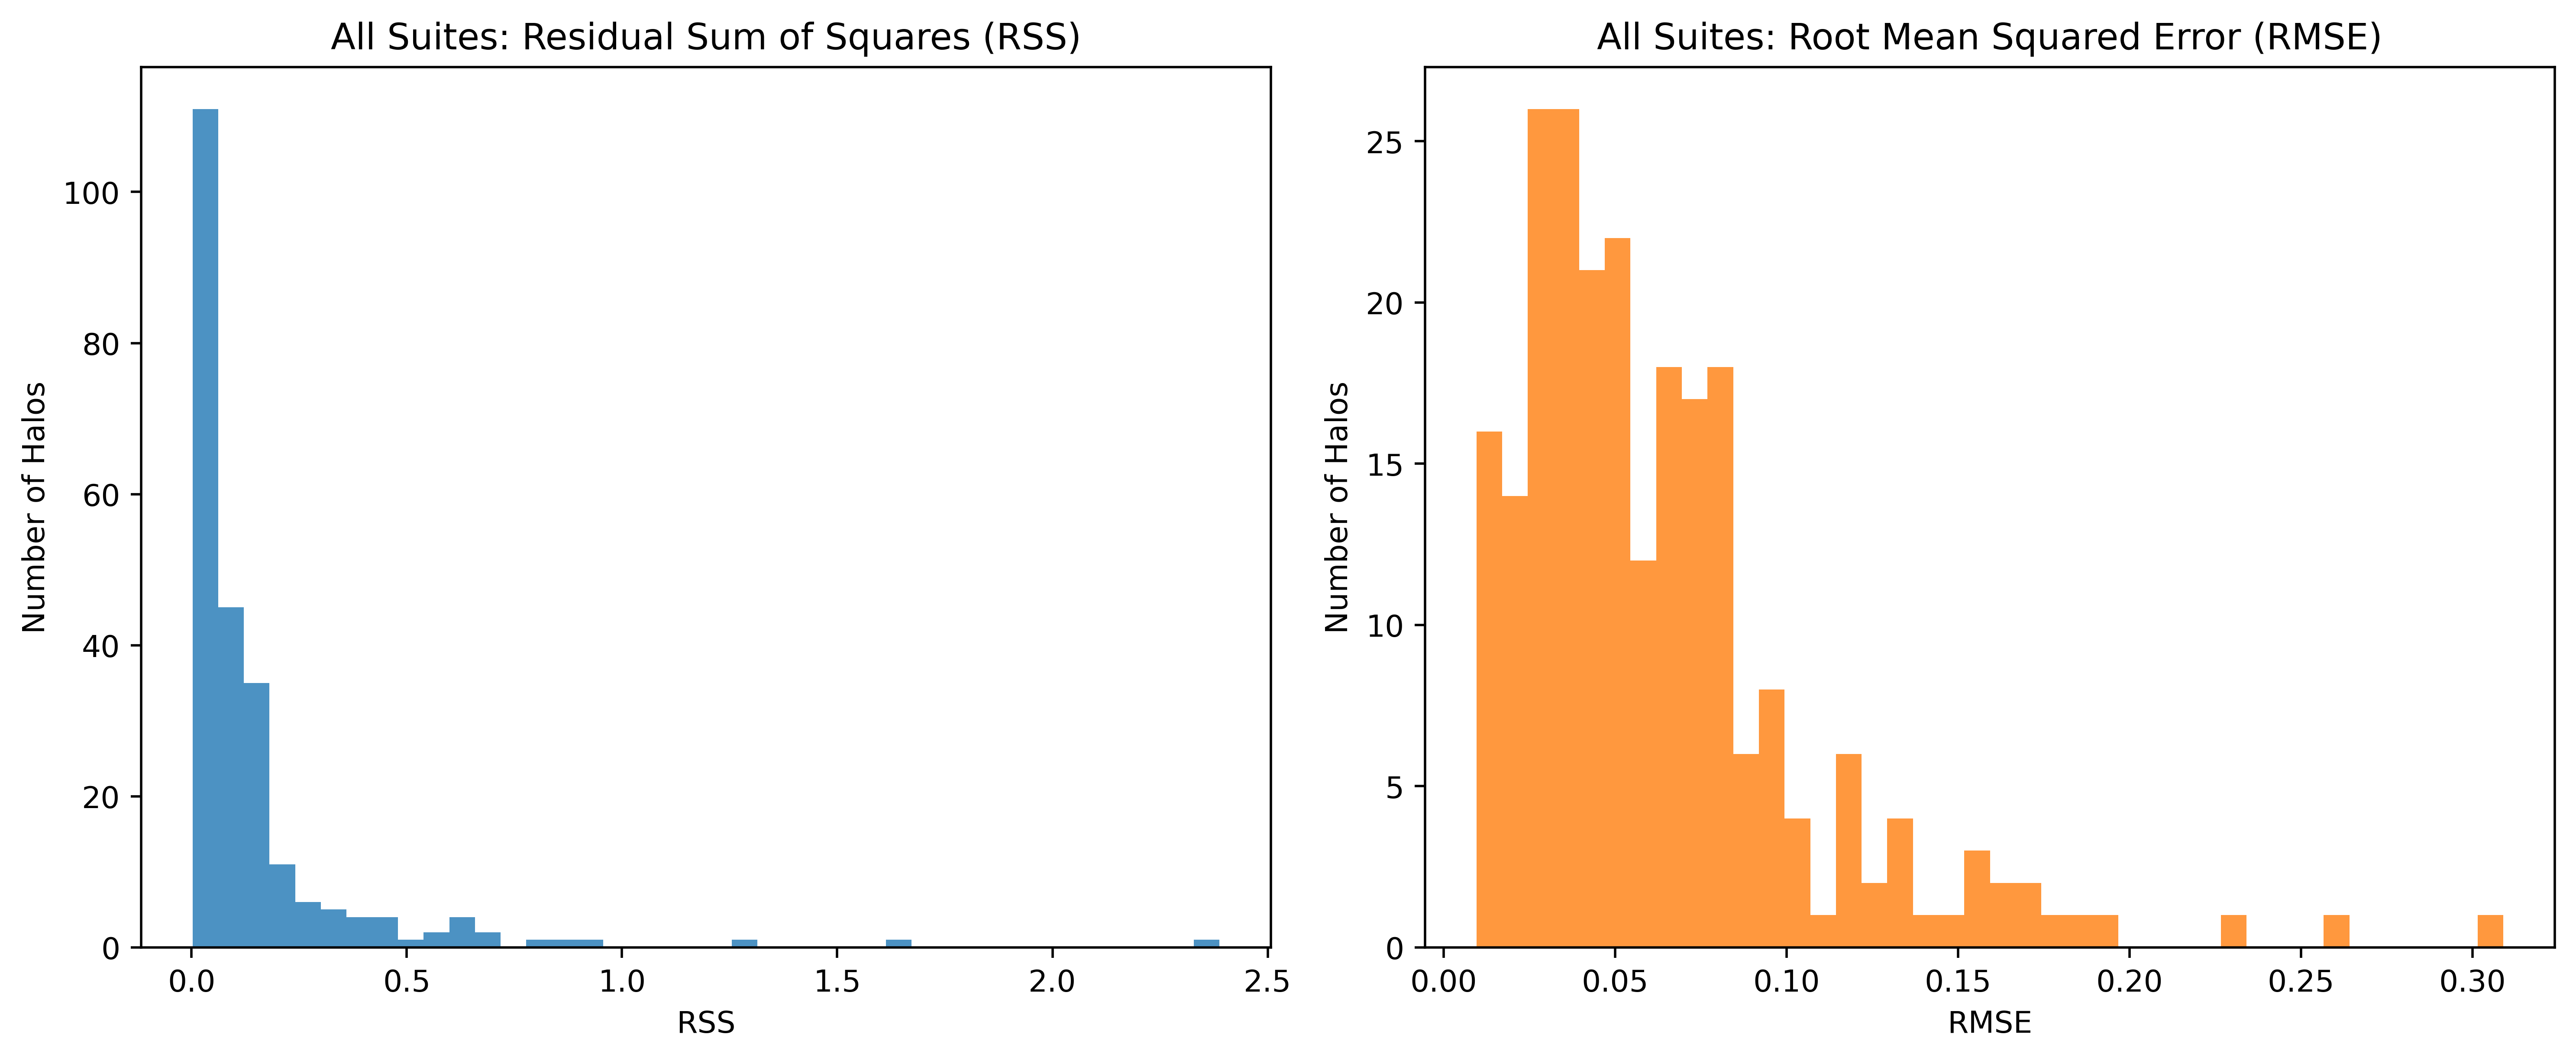

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def running_power_law_model(r, a, b):
    return -(2 + a * r) / (1 + b * r)

def compute_and_plot_suite_fit_errors(base_dir, suite):
    slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
    files = sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")])

    results = []

    for f in files:
        halo_id = f.split(".csv")[0].replace("halo_", "")
        df = pd.read_csv(os.path.join(slope_dir, f))
        r = df["r_scaled"].values
        slope = df["slope_Q_r"].values

        # Valid mask
        mask = (r >= 0.01) & (r <= 1.0) & np.isfinite(slope)
        r_fit = r[mask]
        y_fit = slope[mask]
        if len(r_fit) == 0 or len(y_fit) == 0:
            continue

        try:
            popt, _ = curve_fit(running_power_law_model, r_fit, y_fit, p0=[1.0, 1.0])
            y_model = running_power_law_model(r_fit, *popt)
            residuals = y_fit - y_model
            rss = np.sum(residuals**2)
            rmse = np.sqrt(rss / len(r_fit))
            results.append({
                "halo_id": halo_id,
                "a": popt[0],
                "b": popt[1],
                "RSS": rss,
                "RMSE": rmse
            })
        except RuntimeError:
            continue 

    df_results = pd.DataFrame(results)

    # Plot RSS and RMSE histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

    ax1.hist(df_results["RSS"], bins=30, color="tab:blue", alpha=0.8)
    ax1.set_xlabel("RSS")
    ax1.set_ylabel("Number of Halos")
    ax1.set_title(f"{suite}: Residual Sum of Squares (RSS)")

    ax2.hist(df_results["RMSE"], bins=30, color="tab:orange", alpha=0.8)
    ax2.set_xlabel("RMSE")
    ax2.set_ylabel("Number of Halos")
    ax2.set_title(f"{suite}: Root Mean Squared Error (RMSE)")

    plt.tight_layout()
    plt.show()

    return df_results

def plot_global_fit_error_distribution(df_all_errors):
    rss_vals = df_all_errors["RSS"].values
    rmse_vals = df_all_errors["RMSE"].values

    # Statistics
    mean_rmse = np.mean(rmse_vals)
    std_rmse = np.std(rmse_vals)
    n_total = len(rmse_vals)
    n_good = np.sum(rmse_vals < 0.05)
    n_bad = np.sum(rmse_vals > 0.1)

    print("  Global RMSE Statistics:")
    print(f"  Total halos      = {n_total}")
    print(f"  Mean RMSE        = {mean_rmse:.4f}")
    print(f"  Std. dev of RMSE = {std_rmse:.4f}")
    print(f"  RMSE < 0.05      = {n_good} halos ({n_good/n_total:.1%})")
    print(f"  RMSE > 0.10      = {n_bad} halos ({n_bad/n_total:.1%})")

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

    ax1.hist(rss_vals, bins=40, color="tab:blue", alpha=0.8)
    ax1.set_xlabel("RSS")
    ax1.set_ylabel("Number of Halos")
    ax1.set_title("All Suites: Residual Sum of Squares (RSS)")

    ax2.hist(rmse_vals, bins=40, color="tab:orange", alpha=0.8)
    ax2.set_xlabel("RMSE")
    ax2.set_ylabel("Number of Halos")
    ax2.set_title("All Suites: Root Mean Squared Error (RMSE)")

    plt.tight_layout()
    plt.show()

def compute_and_plot_all_suites_fit_errors(base_dir, suite_names):
    all_results = []

    for suite in suite_names:
        print(f"\n▶ Processing suite: {suite}")
        df_suite = compute_and_plot_suite_fit_errors(base_dir, suite)
        df_suite["suite"] = suite
        all_results.append(df_suite)

    df_all = pd.concat(all_results, ignore_index=True)

    return df_all

plot_global_fit_error_distribution(df_all_errors)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def constant_slope_model(r, chi):
    """Return constant logarithmic slope γ(r) = −χ."""
    return -chi * np.ones_like(r)

def compute_and_plot_suite_const_fit_errors(base_dir, suite):
    slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
    files = sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")])

    results = []

    for f in files:
        halo_id = f.split(".csv")[0].replace("halo_", "")
        df = pd.read_csv(os.path.join(slope_dir, f))
        r = df["r_scaled"].values
        slope = df["slope_Q_r"].values

        # fit over the same radial window as before
        mask = (r >= 0.01) & (r <= 1.0) & np.isfinite(slope)
        r_fit, y_fit = r[mask], slope[mask]
        if len(r_fit) == 0:
            continue

        try:
            # initial guess χ = 2
            popt, _ = curve_fit(constant_slope_model, r_fit, y_fit, p0=[2.0])
            chi = popt[0]

            y_model = constant_slope_model(r_fit, chi)
            residuals = y_fit - y_model
            rss = np.sum(residuals**2)
            rmse = np.sqrt(rss / len(r_fit))

            results.append({
                "halo_id": halo_id,
                "chi": chi,
                "RSS": rss,
                "RMSE": rmse
            })

        except RuntimeError:
            continue

    df_results = pd.DataFrame(results)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

    ax1.hist(df_results["RSS"], bins=30, color="tab:purple", alpha=0.8)
    ax1.set_xlabel("RSS")
    ax1.set_ylabel("Number of Halos")
    ax1.set_title(f"{suite}: RSS (constant-slope)")

    ax2.hist(df_results["RMSE"], bins=30, color="tab:pink", alpha=0.8)
    ax2.set_xlabel("RMSE")
    ax2.set_ylabel("Number of Halos")
    ax2.set_title(f"{suite}: RMSE (constant-slope)")

    plt.tight_layout()
    plt.show()

    return df_results

def compute_and_plot_all_suites_const_fit_errors(base_dir, suite_names):
    """
    Run constant-slope fits for every suite, concatenate results,
    and return a combined DataFrame.
    """
    all_results = []

    for suite in suite_names:
        print(f"\n▶ Processing suite (constant slope): {suite}")
        df_suite = compute_and_plot_suite_const_fit_errors(base_dir, suite)
        df_suite["suite"] = suite
        all_results.append(df_suite)

    df_all = pd.concat(all_results, ignore_index=True)
    return df_all

def plot_global_const_fit_error_distribution(df_all_errors):
    """Plot global RSS/RMSE distributions for the constant-slope model."""
    rss_vals = df_all_errors["RSS"].values
    rmse_vals = df_all_errors["RMSE"].values

    mean_rmse = np.mean(rmse_vals)
    std_rmse = np.std(rmse_vals)
    n_total = len(rmse_vals)
    n_good = np.sum(rmse_vals < 0.05)
    n_bad = np.sum(rmse_vals > 0.10)

    print("  Global RMSE Statistics (constant slope):")
    print(f"  Total halos      = {n_total}")
    print(f"  Mean RMSE        = {mean_rmse:.4f}")
    print(f"  Std. dev of RMSE = {std_rmse:.4f}")
    print(f"  RMSE < 0.05      = {n_good} halos ({n_good/n_total:.1%})")
    print(f"  RMSE > 0.10      = {n_bad} halos ({n_bad/n_total:.1%})")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

    ax1.hist(rss_vals, bins=40, color="tab:purple", alpha=0.8)
    ax1.set_xlabel("RSS")
    ax1.set_ylabel("Number of Halos")
    ax1.set_title("All Suites: RSS (constant-slope)")

    ax2.hist(rmse_vals, bins=40, color="tab:pink", alpha=0.8)
    ax2.set_xlabel("RMSE")
    ax2.set_ylabel("Number of Halos")
    ax2.set_title("All Suites: RMSE (constant-slope)")

    plt.tight_layout()
    plt.show()

plot_global_const_fit_error_distribution(df_const = compute_and_plot_all_suites_const_fit_errors(base_dir, suite_names))


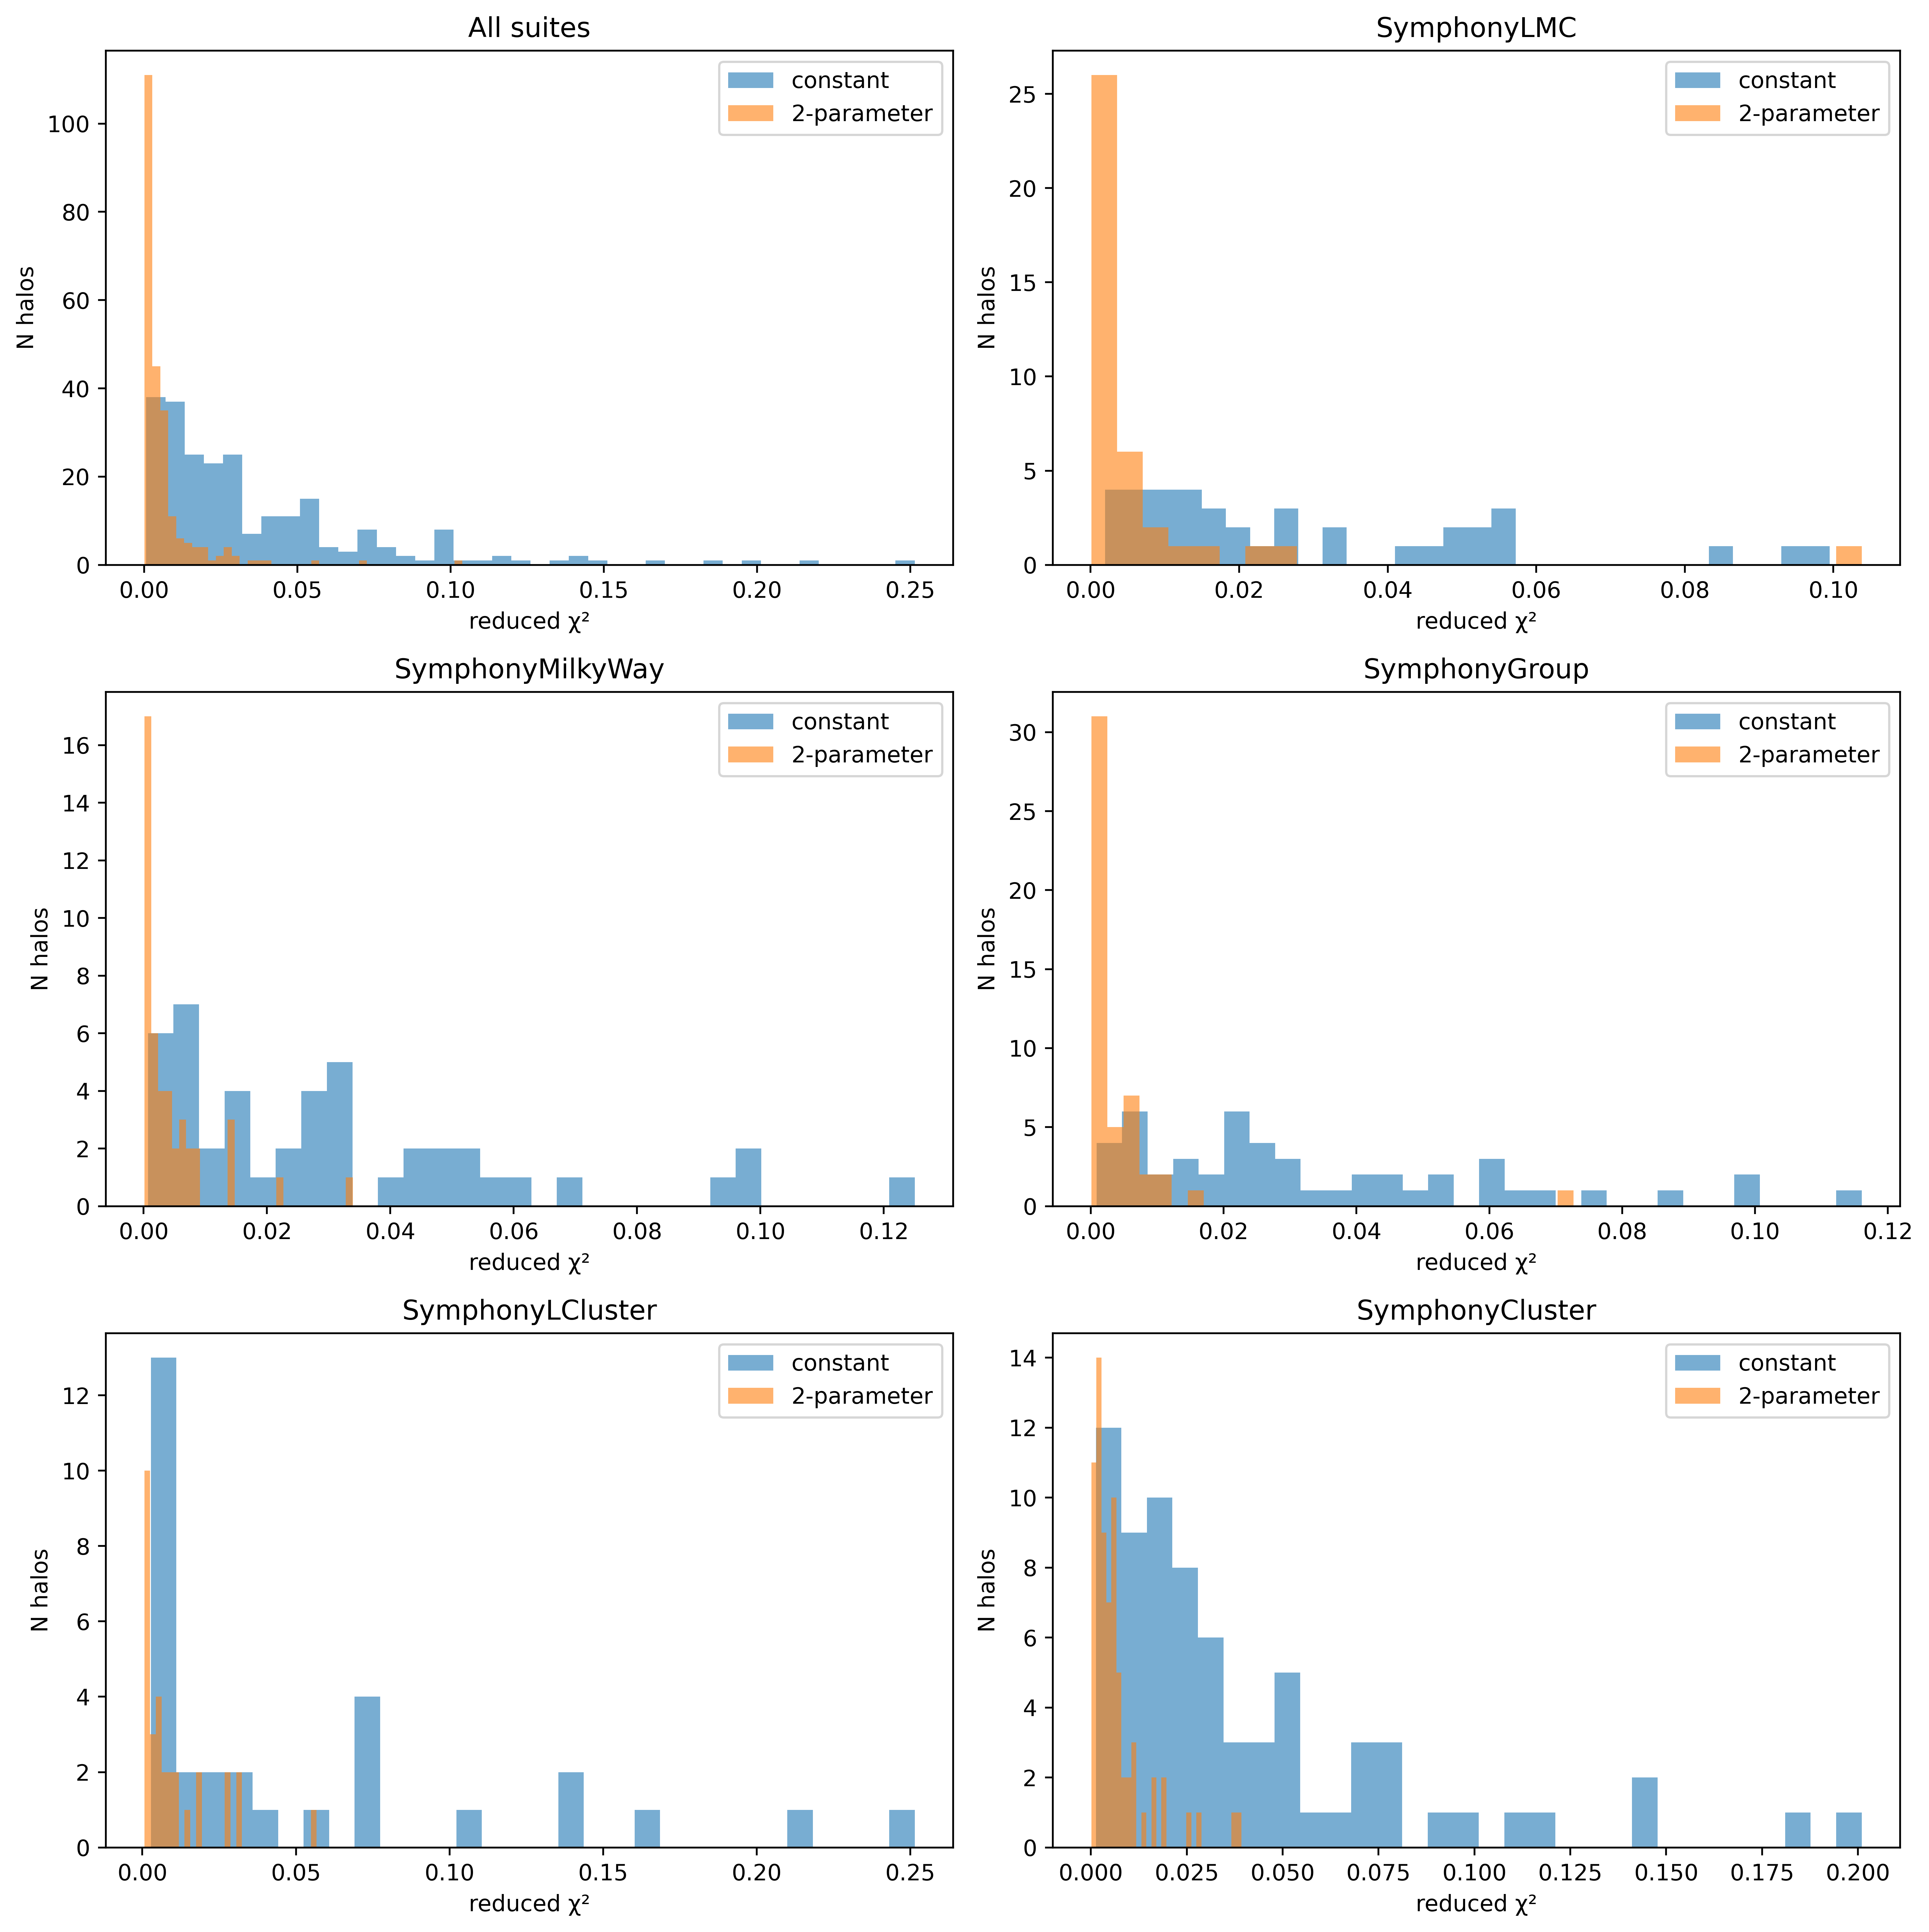

           suite  N_const  mean_const  median_const  N_2par  mean_2par  median_2par    Δmean  Δmedian
             ALL      236    0.036912      0.023938     236   0.006388     0.002863 0.030524 0.021074
     SymphonyLMC       39    0.029069      0.019948      39   0.006898     0.002310 0.022171 0.017638
SymphonyMilkyWay       45    0.031392      0.027075      45   0.004612     0.002344 0.026780 0.024731
   SymphonyGroup       49    0.033916      0.024651      49   0.004498     0.001625 0.029418 0.023026
SymphonyLCluster       31    0.052524      0.019860      31   0.010557     0.005376 0.041967 0.014483
 SymphonyCluster       72    0.039928      0.025428      72   0.006713     0.004522 0.033215 0.020906


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ------------------------------------------------------------
# MODELS
# ------------------------------------------------------------
def constant_slope_model(r, chi):
    return -chi * np.ones_like(r)                         # 1-parameter

def gamma_model(r, a, b):
    return -(2 + a * r) / (1 + b * r)                     # 2-parameter

# ------------------------------------------------------------
# χ² UTILS
# ------------------------------------------------------------
def reduced_chi2(r, y, model, params, sigma=1.0):
    resid = (y - model(r, *params)) / sigma
    chi2_val = np.sum(resid**2)
    dof = len(r) - len(params)
    return chi2_val / dof

# ------------------------------------------------------------
# MAIN DRIVER
# ------------------------------------------------------------
def calc_reduced_chi2(base_dir, suite_names):
    rec_const, rec_gamma = [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        files = sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv"))

        for f in files:
            halo_id = f.split(".csv")[0].replace("halo_", "")
            df = pd.read_csv(os.path.join(slope_dir, f))
            r_all, y_all = df["r_scaled"].values, df["slope_Q_r"].values

            mask = (r_all >= 0.01) & (r_all <= 1.0) & np.isfinite(y_all)
            r, y = r_all[mask], y_all[mask]
            if len(r) < 3:
                continue

            try:
                p_c, _ = curve_fit(constant_slope_model, r, y, p0=[2.0])
                rec_const.append(
                    {"suite": suite, "halo_id": halo_id,
                     "red_chi2": reduced_chi2(r, y, constant_slope_model, p_c)}
                )
            except RuntimeError:
                pass

            try:
                p_g, _ = curve_fit(gamma_model, r, y, p0=[1.0, 1.0])
                rec_gamma.append(
                    {"suite": suite, "halo_id": halo_id,
                     "red_chi2": reduced_chi2(r, y, gamma_model, p_g)}
                )
            except RuntimeError:
                pass

    return pd.DataFrame(rec_const), pd.DataFrame(rec_gamma)

# ------------------------------------------------------------
# SUMMARY TABLE
# ------------------------------------------------------------
def summary_stats(df_const, df_gamma, suite_names):
    rows = []
    for suite in ["ALL"] + suite_names:
        if suite == "ALL":
            c_vals = df_const["red_chi2"].values
            g_vals = df_gamma["red_chi2"].values
        else:
            c_vals = df_const.loc[df_const["suite"] == suite, "red_chi2"].values
            g_vals = df_gamma.loc[df_gamma["suite"] == suite, "red_chi2"].values

        if len(c_vals) == 0 or len(g_vals) == 0:
            continue

        rows.append({
            "suite"      : suite,
            "N_const"    : len(c_vals),
            "mean_const" : np.mean(c_vals),
            "median_const": np.median(c_vals),
            "N_2par"     : len(g_vals),
            "mean_2par"  : np.mean(g_vals),
            "median_2par": np.median(g_vals),
            "Δmean"      : np.mean(c_vals) - np.mean(g_vals),
            "Δmedian"    : np.median(c_vals) - np.median(g_vals)
        })

    return pd.DataFrame(rows)

# ------------------------------------------------------------
# PLOTTER
# ------------------------------------------------------------
def plot_reduced_chi2_histograms(df_const, df_gamma, suite_names):
    n_suites = len(suite_names)
    n_cols, n_rows = 2, (n_suites + 1 + 1) // 2  # +1 global

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), dpi=500)
    axes = axes.flatten()

    # global
    axes[0].hist(df_const["red_chi2"], bins=40, alpha=0.6,
                 label="constant", color="tab:blue")
    axes[0].hist(df_gamma["red_chi2"], bins=40, alpha=0.6,
                 label="2-parameter", color="tab:orange")
    axes[0].set(title="All suites", xlabel="reduced χ²", ylabel="N halos")
    axes[0].legend()

    # per suite
    for i, suite in enumerate(suite_names, start=1):
        c = df_const.loc[df_const["suite"] == suite, "red_chi2"]
        g = df_gamma.loc[df_gamma["suite"] == suite, "red_chi2"]
        axes[i].hist(c, bins=30, alpha=0.6, label="constant", color="tab:blue")
        axes[i].hist(g, bins=30, alpha=0.6, label="2-parameter", color="tab:orange")
        axes[i].set(title=suite, xlabel="reduced χ²", ylabel="N halos")
        axes[i].legend()

    for ax in axes[len(suite_names)+1:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


df_const, df_gamma = calc_reduced_chi2(base_dir, suite_names)
plot_reduced_chi2_histograms(df_const, df_gamma, suite_names)

stats = summary_stats(df_const, df_gamma, suite_names)
print(stats.to_string(index=False)) 


           suite   N  median_ΔBIC  mean_ΔBIC  frac_ΔBIC>6  frac_ΔBIC>10
             ALL 236    -2.743238  -2.479909          0.0           0.0
     SymphonyLMC  39    -2.891992  -2.679868          0.0           0.0
SymphonyMilkyWay  45    -2.709503  -2.571552          0.0           0.0
   SymphonyGroup  49    -2.664246  -2.508348          0.0           0.0
SymphonyLCluster  31    -2.884225  -2.201116          0.0           0.0
 SymphonyCluster  72    -2.754423  -2.415003          0.0           0.0


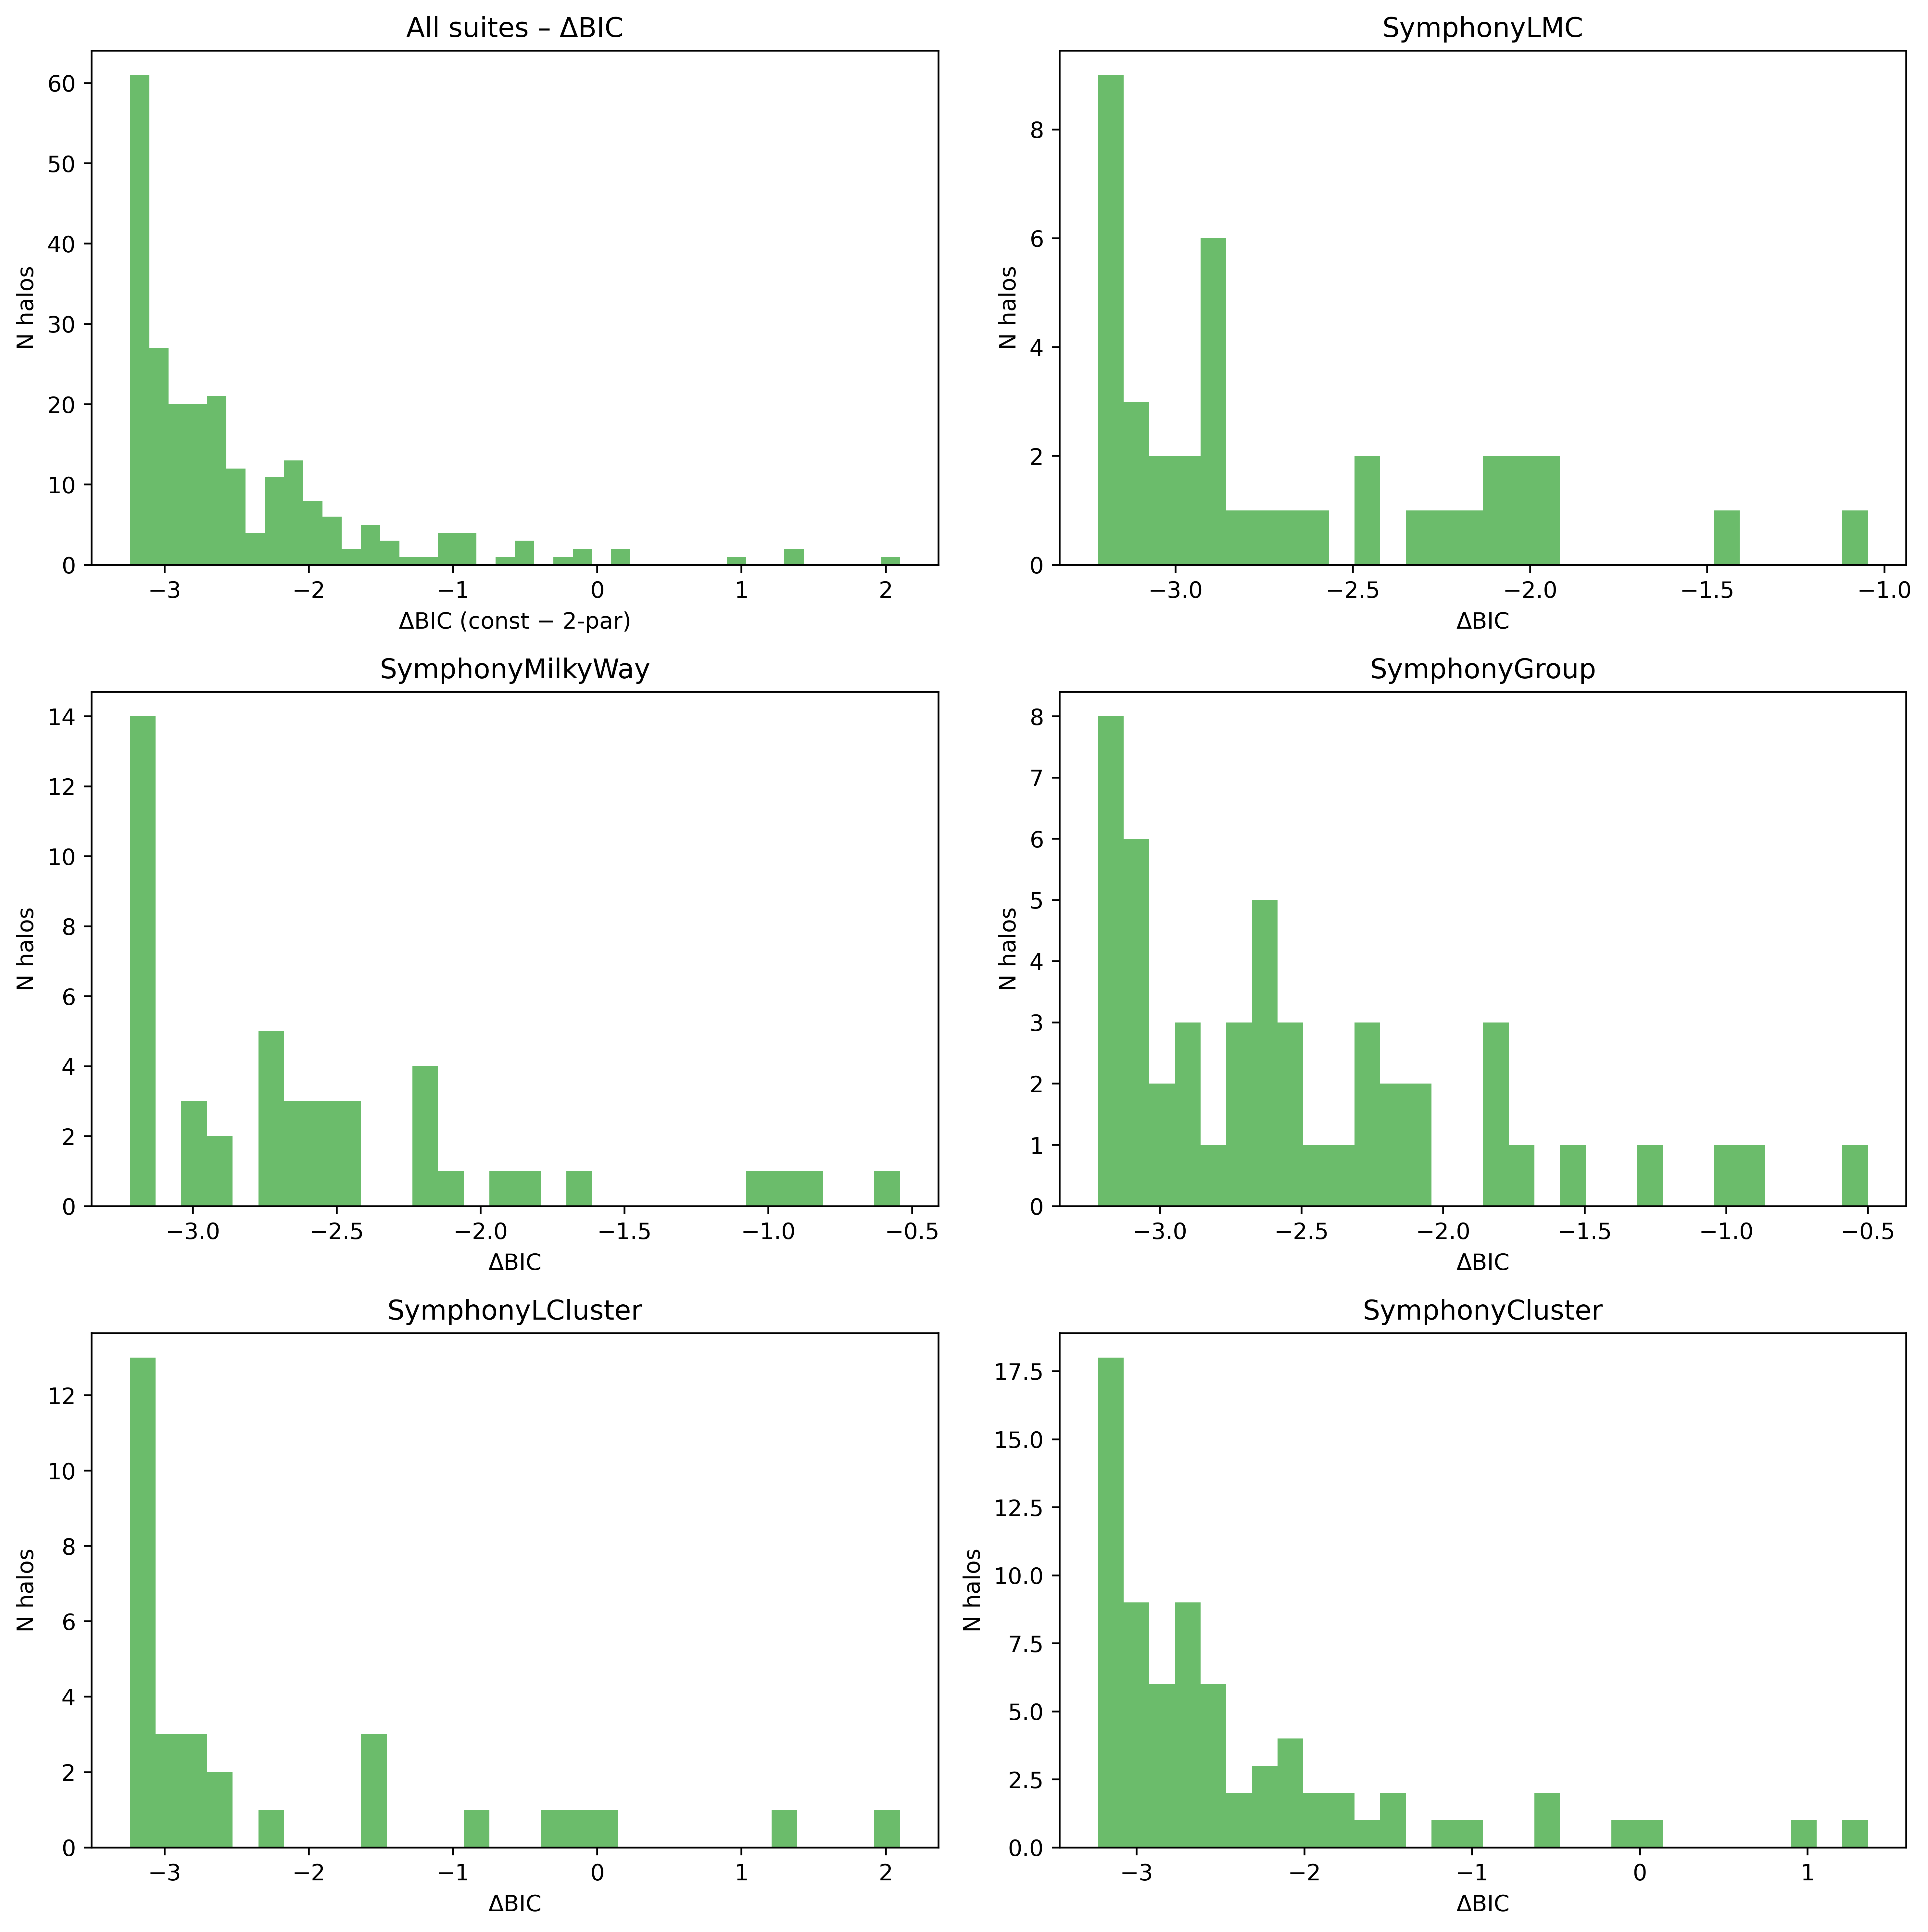

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ------------------------------------------------------------
# MODELS
# ------------------------------------------------------------
def constant_slope_model(r, chi):
    """Constant PPSD slope (1-parameter)."""
    return -chi * np.ones_like(r)

def gamma_model(r, a, b):
    """Radius-dependent slope (2-parameter)."""
    return -(2 + a * r) / (1 + b * r)

# ------------------------------------------------------------
# BIC
# ------------------------------------------------------------
def bic_value(r, y, model_func, params, sigma=1.0):
    """BIC = χ² + k*ln(N),  χ² = Σ[(y-ŷ)/σ]²  (σ≡1 here)."""
    resid = (y - model_func(r, *params)) / sigma
    chi2  = np.sum(resid**2)
    n, k  = len(r), len(params)
    return chi2 + k * np.log(n)

def calc_bic(base_dir, suite_names):
    """Return two DataFrames with BIC for both models."""
    rec_const, rec_gamma = [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        for f in sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")]):
            halo_id = f.split(".csv")[0].replace("halo_", "")
            df = pd.read_csv(os.path.join(slope_dir, f))
            r_all, y_all = df["r_scaled"].values, df["slope_Q_r"].values

            m = (r_all >= 0.01) & (r_all <= 1.0) & np.isfinite(y_all)
            r, y = r_all[m], y_all[m]
            if len(r) < 3:
                continue

            # constant
            try:
                pc, _ = curve_fit(constant_slope_model, r, y, p0=[2.0])
                rec_const.append({"suite": suite, "halo_id": halo_id,
                                  "bic": bic_value(r, y, constant_slope_model, pc)})
            except RuntimeError:
                pass

            # 2-parameter
            try:
                pg, _ = curve_fit(gamma_model, r, y, p0=[1.0, 1.0])
                rec_gamma.append({"suite": suite, "halo_id": halo_id,
                                  "bic": bic_value(r, y, gamma_model, pg)})
            except RuntimeError:
                pass

    return pd.DataFrame(rec_const), pd.DataFrame(rec_gamma)

# ------------------------------------------------------------
# ΔBIC + SUMMARY
# ------------------------------------------------------------
def delta_bic_table(df_const, df_gamma, suite_names):
    """Merge, compute ΔBIC = BIC_const - BIC_2par, return summary table."""
    df = df_const.merge(df_gamma, on=["suite", "halo_id"], suffixes=("_const", "_2par"))
    df["delta_bic"] = df["bic_const"] - df["bic_2par"]   # >0 → 2-par better

    rows = []
    for suite in ["ALL"] + suite_names:
        sel = df if suite == "ALL" else df[df["suite"] == suite]
        if sel.empty:
            continue
        rows.append({
            "suite": suite,
            "N": len(sel),
            "median_ΔBIC": np.median(sel["delta_bic"]),
            "mean_ΔBIC": np.mean(sel["delta_bic"]),
            "frac_ΔBIC>6": np.mean(sel["delta_bic"] > 6),
            "frac_ΔBIC>10": np.mean(sel["delta_bic"] > 10)
        })
    return pd.DataFrame(rows), df

# ------------------------------------------------------------
# PLOTS
# ------------------------------------------------------------
def plot_delta_bic_hist(df_delta, suite_names):
    """Histograms of ΔBIC (global + per suite)."""
    n_suites, n_cols = len(suite_names), 2
    n_rows = (n_suites + 1 + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), dpi=500)
    axes = axes.flatten()

    # global
    axes[0].hist(df_delta["delta_bic"], bins=40, color="tab:green", alpha=0.7)
    axes[0].set(title="All suites – ΔBIC", xlabel="ΔBIC (const − 2-par)", ylabel="N halos")

    # per suite
    for i, suite in enumerate(suite_names, start=1):
        vals = df_delta.loc[df_delta["suite"] == suite, "delta_bic"]
        axes[i].hist(vals, bins=30, color="tab:green", alpha=0.7)
        axes[i].set(title=suite, xlabel="ΔBIC", ylabel="N halos")

    for ax in axes[len(suite_names)+1:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

df_c, df_g = calc_bic(base_dir, suite_names)
summary, df_delta = delta_bic_table(df_c, df_g, suite_names)
print(summary.to_string(index=False))     # quantitative ΔBIC stats
plot_delta_bic_hist(df_delta, suite_names)


 Fitted gamma_Q(r): a = 2.7519, b = 1.9426
 Fitted normalization: Q0 = 2.2873e+02


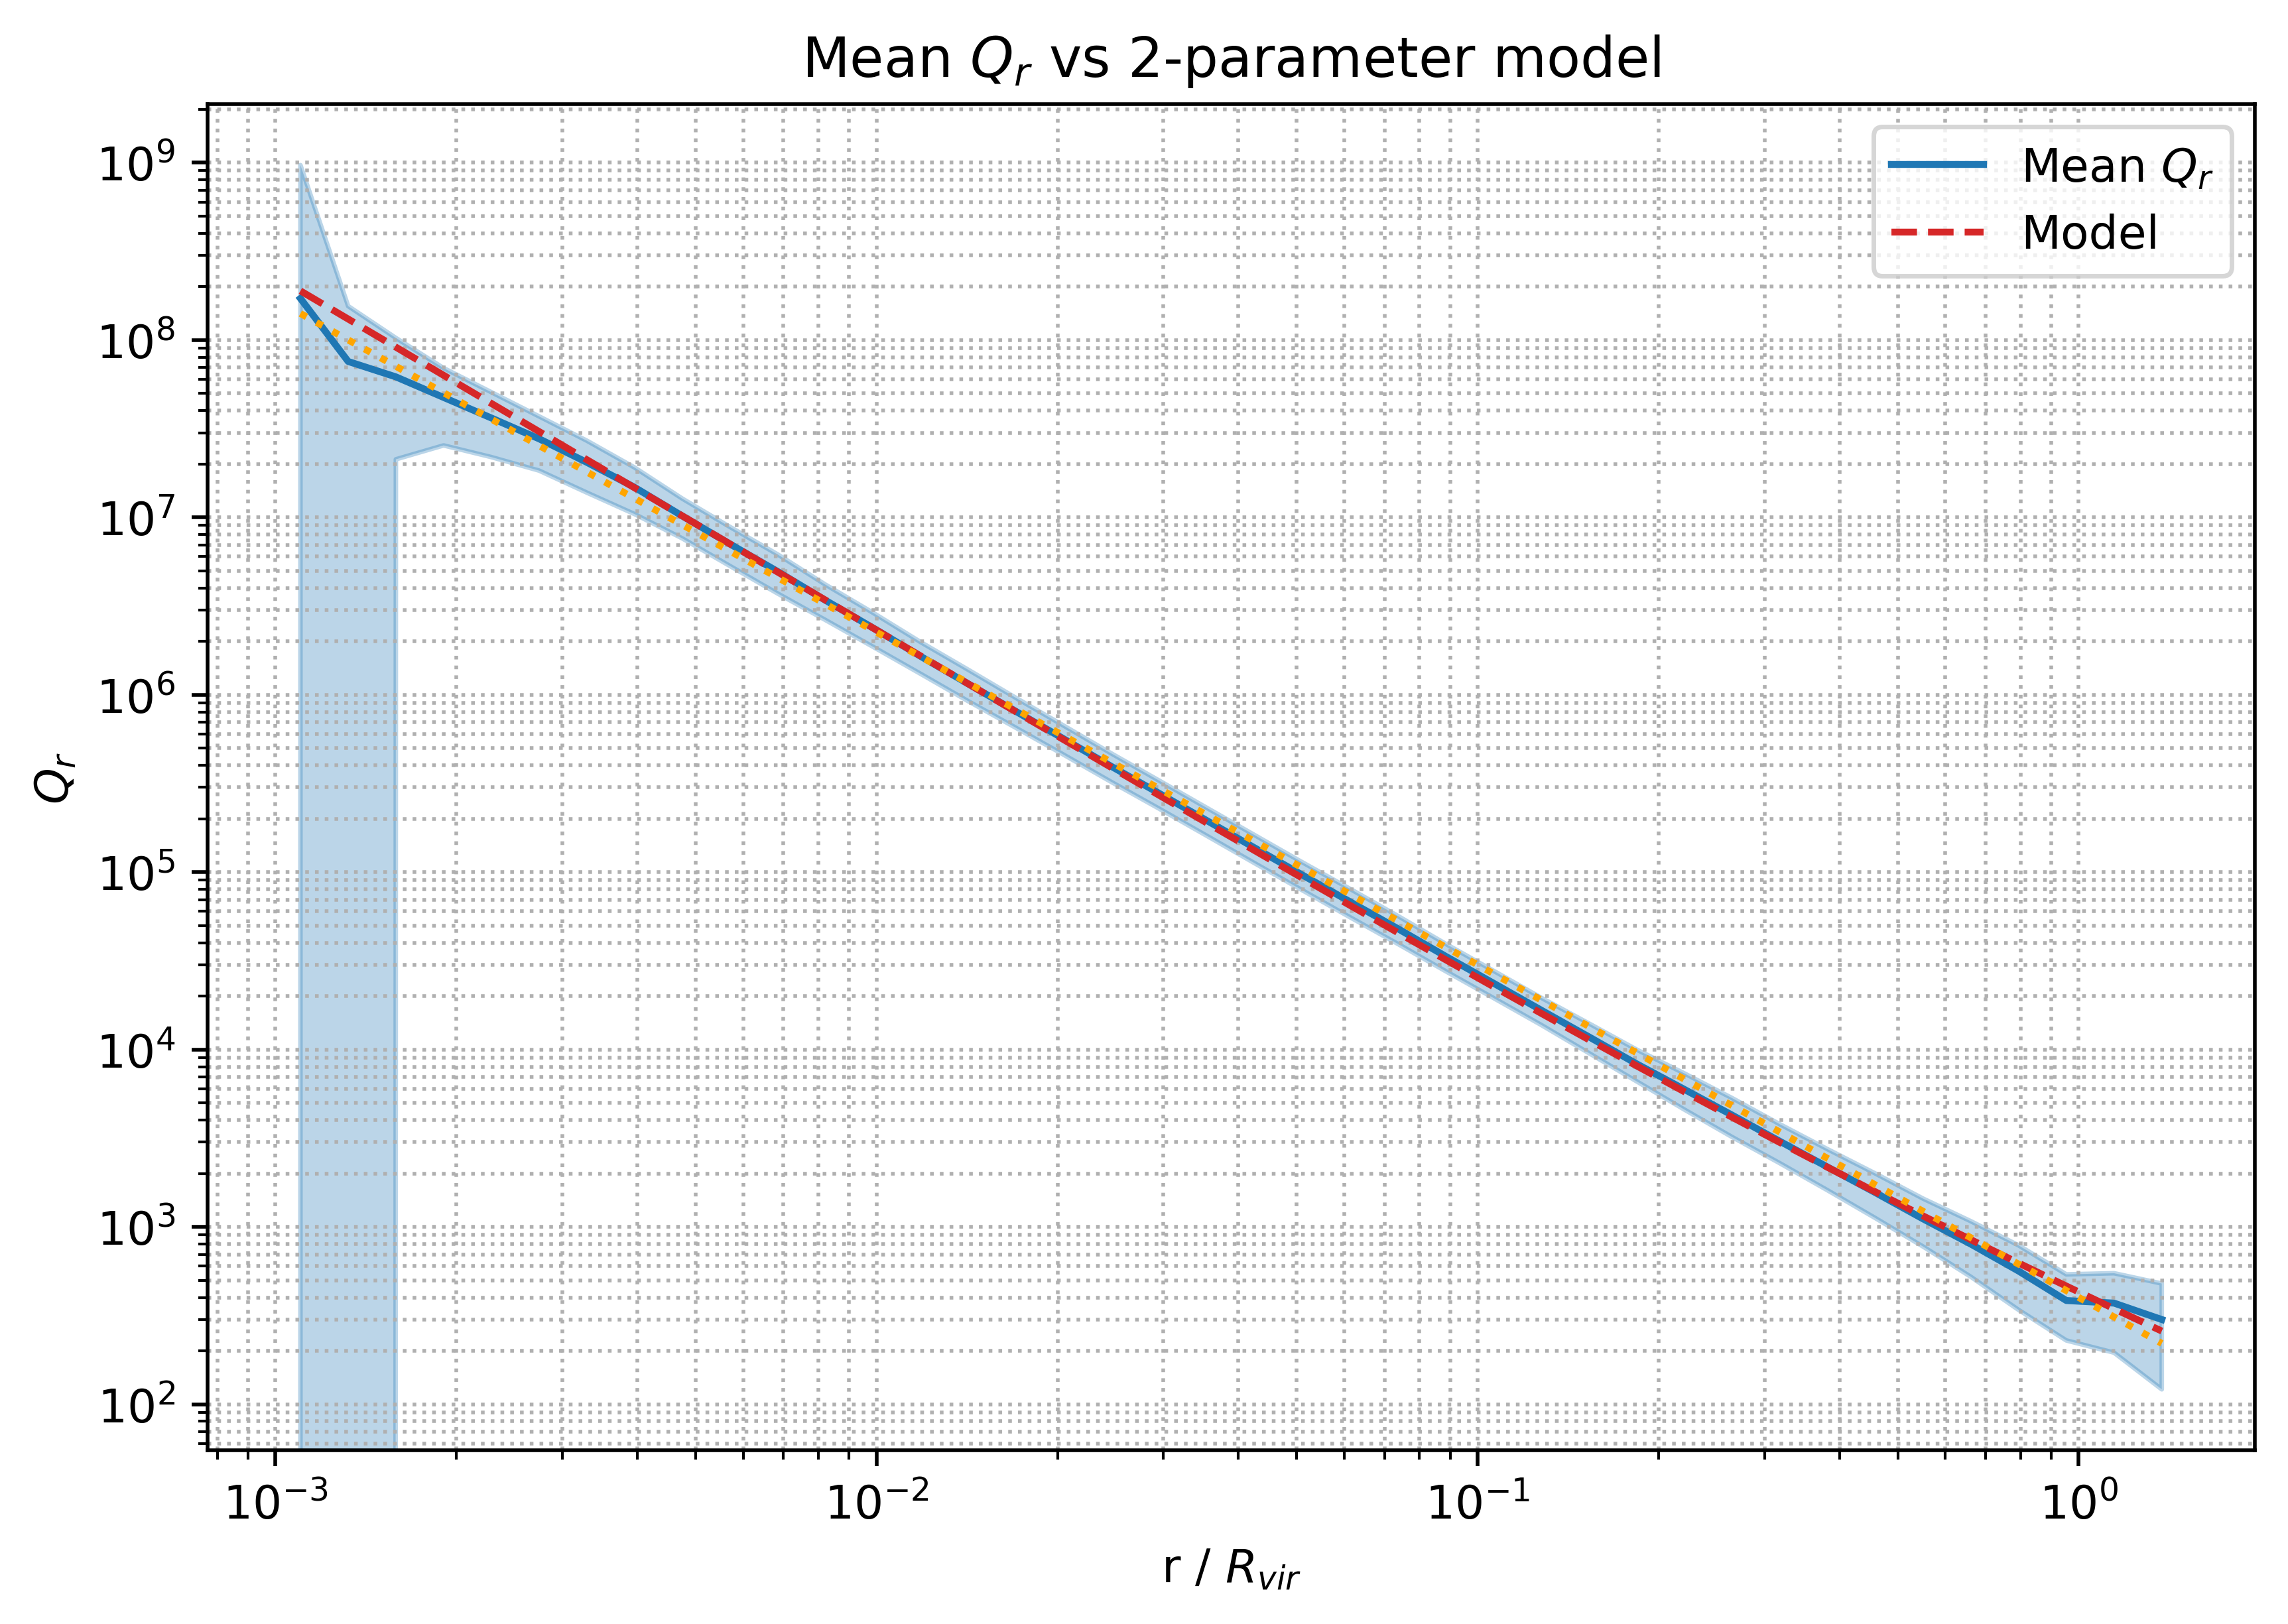

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Two-parameter slope model
def gamma_Q_model(r, a, b):
    return -(2 + a * r) / (1 + b * r)

# Integrated Q(r) from gamma_Q
def Q_model(r, Q0, a, b):
    exponent = -(a - 2*b) / b
    return Q0 * r**(-2) * (1 + b * r)**exponent

def fit_and_compare_ppsd_vs_model(base_dir, suite_names):
    slope_r_all, Qr_all, r_grid_ref = [], [], None

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        Q_dir     = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        slope_files = sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")])
        Q_files     = sorted([f for f in os.listdir(Q_dir) if f.endswith(".csv")])

        for fs, fq in zip(slope_files, Q_files):
            dfs = pd.read_csv(os.path.join(slope_dir, fs))
            dfq = pd.read_csv(os.path.join(Q_dir, fq))

            r = dfs["r_scaled"].values
            s_Qr = dfs["slope_Q_r"].values
            Qr = dfq["Q_r"].values

            if not (np.all(np.isfinite(r)) and np.all(np.isfinite(s_Qr)) and np.all(np.isfinite(Qr))):
                continue

            if r_grid_ref is None:
                r_grid_ref = r
            if not np.allclose(r, r_grid_ref, rtol=1e-4, atol=1e-6):
                continue

            slope_r_all.append(s_Qr)
            Qr_all.append(Qr)

    slope_r_all = np.array(slope_r_all)
    Qr_all = np.array(Qr_all)
    r = r_grid_ref

    # Mean slope and Q
    mean_slope = np.nanmean(slope_r_all, axis=0)
    std_slope  = np.nanstd(slope_r_all, axis=0)
    mean_Q     = np.nanmean(Qr_all, axis=0)
    std_Q      = np.nanstd(Qr_all, axis=0)

    # Fit gamma model to slope
    mask = (r >= 0.01) & (r <= 1.0) & np.isfinite(mean_slope)
    r_fit = r[mask]
    y_fit = mean_slope[mask]

    popt, _ = curve_fit(gamma_Q_model, r_fit, y_fit, p0=[1.0, 1.0])
    a_fit, b_fit = popt

    print(f" Fitted gamma_Q(r): a = {a_fit:.4f}, b = {b_fit:.4f}")

    # Now fit Q0 using model Q vs mean_Q
    Q_model_vals = lambda r, Q0: Q_model(r, Q0, a_fit, b_fit)
    popt_Q, _ = curve_fit(Q_model_vals, r[mask], mean_Q[mask], p0=[1.0])
    Q0_fit = popt_Q[0]
    print(f" Fitted normalization: Q0 = {Q0_fit:.4e}")

    # Plot comparison
    plt.figure(figsize=(7, 5), dpi=500)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("r / $R_{vir}$")
    plt.ylabel("$Q_r$")
    plt.title("Mean $Q_r$ vs 2-parameter model")

    plt.plot(r, mean_Q, color="tab:blue", label="Mean $Q_r$")
    plt.fill_between(r, mean_Q - std_Q, mean_Q + std_Q, color="tab:blue", alpha=0.3)

    Q_model_fit = Q_model(r, Q0_fit, a_fit, b_fit)
    plt.plot(r, Q_model_fit, color="tab:red", ls="--", lw=1.5, label="Model")
    plt.plot(r, 400*r**(-1.875), color="orange", ls=":", lw=1.5)
    plt.grid(True, which="both", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return a_fit, b_fit, Q0_fit

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

a_fit, b_fit, Q0_fit = fit_and_compare_ppsd_vs_model(base_dir, suite_names)

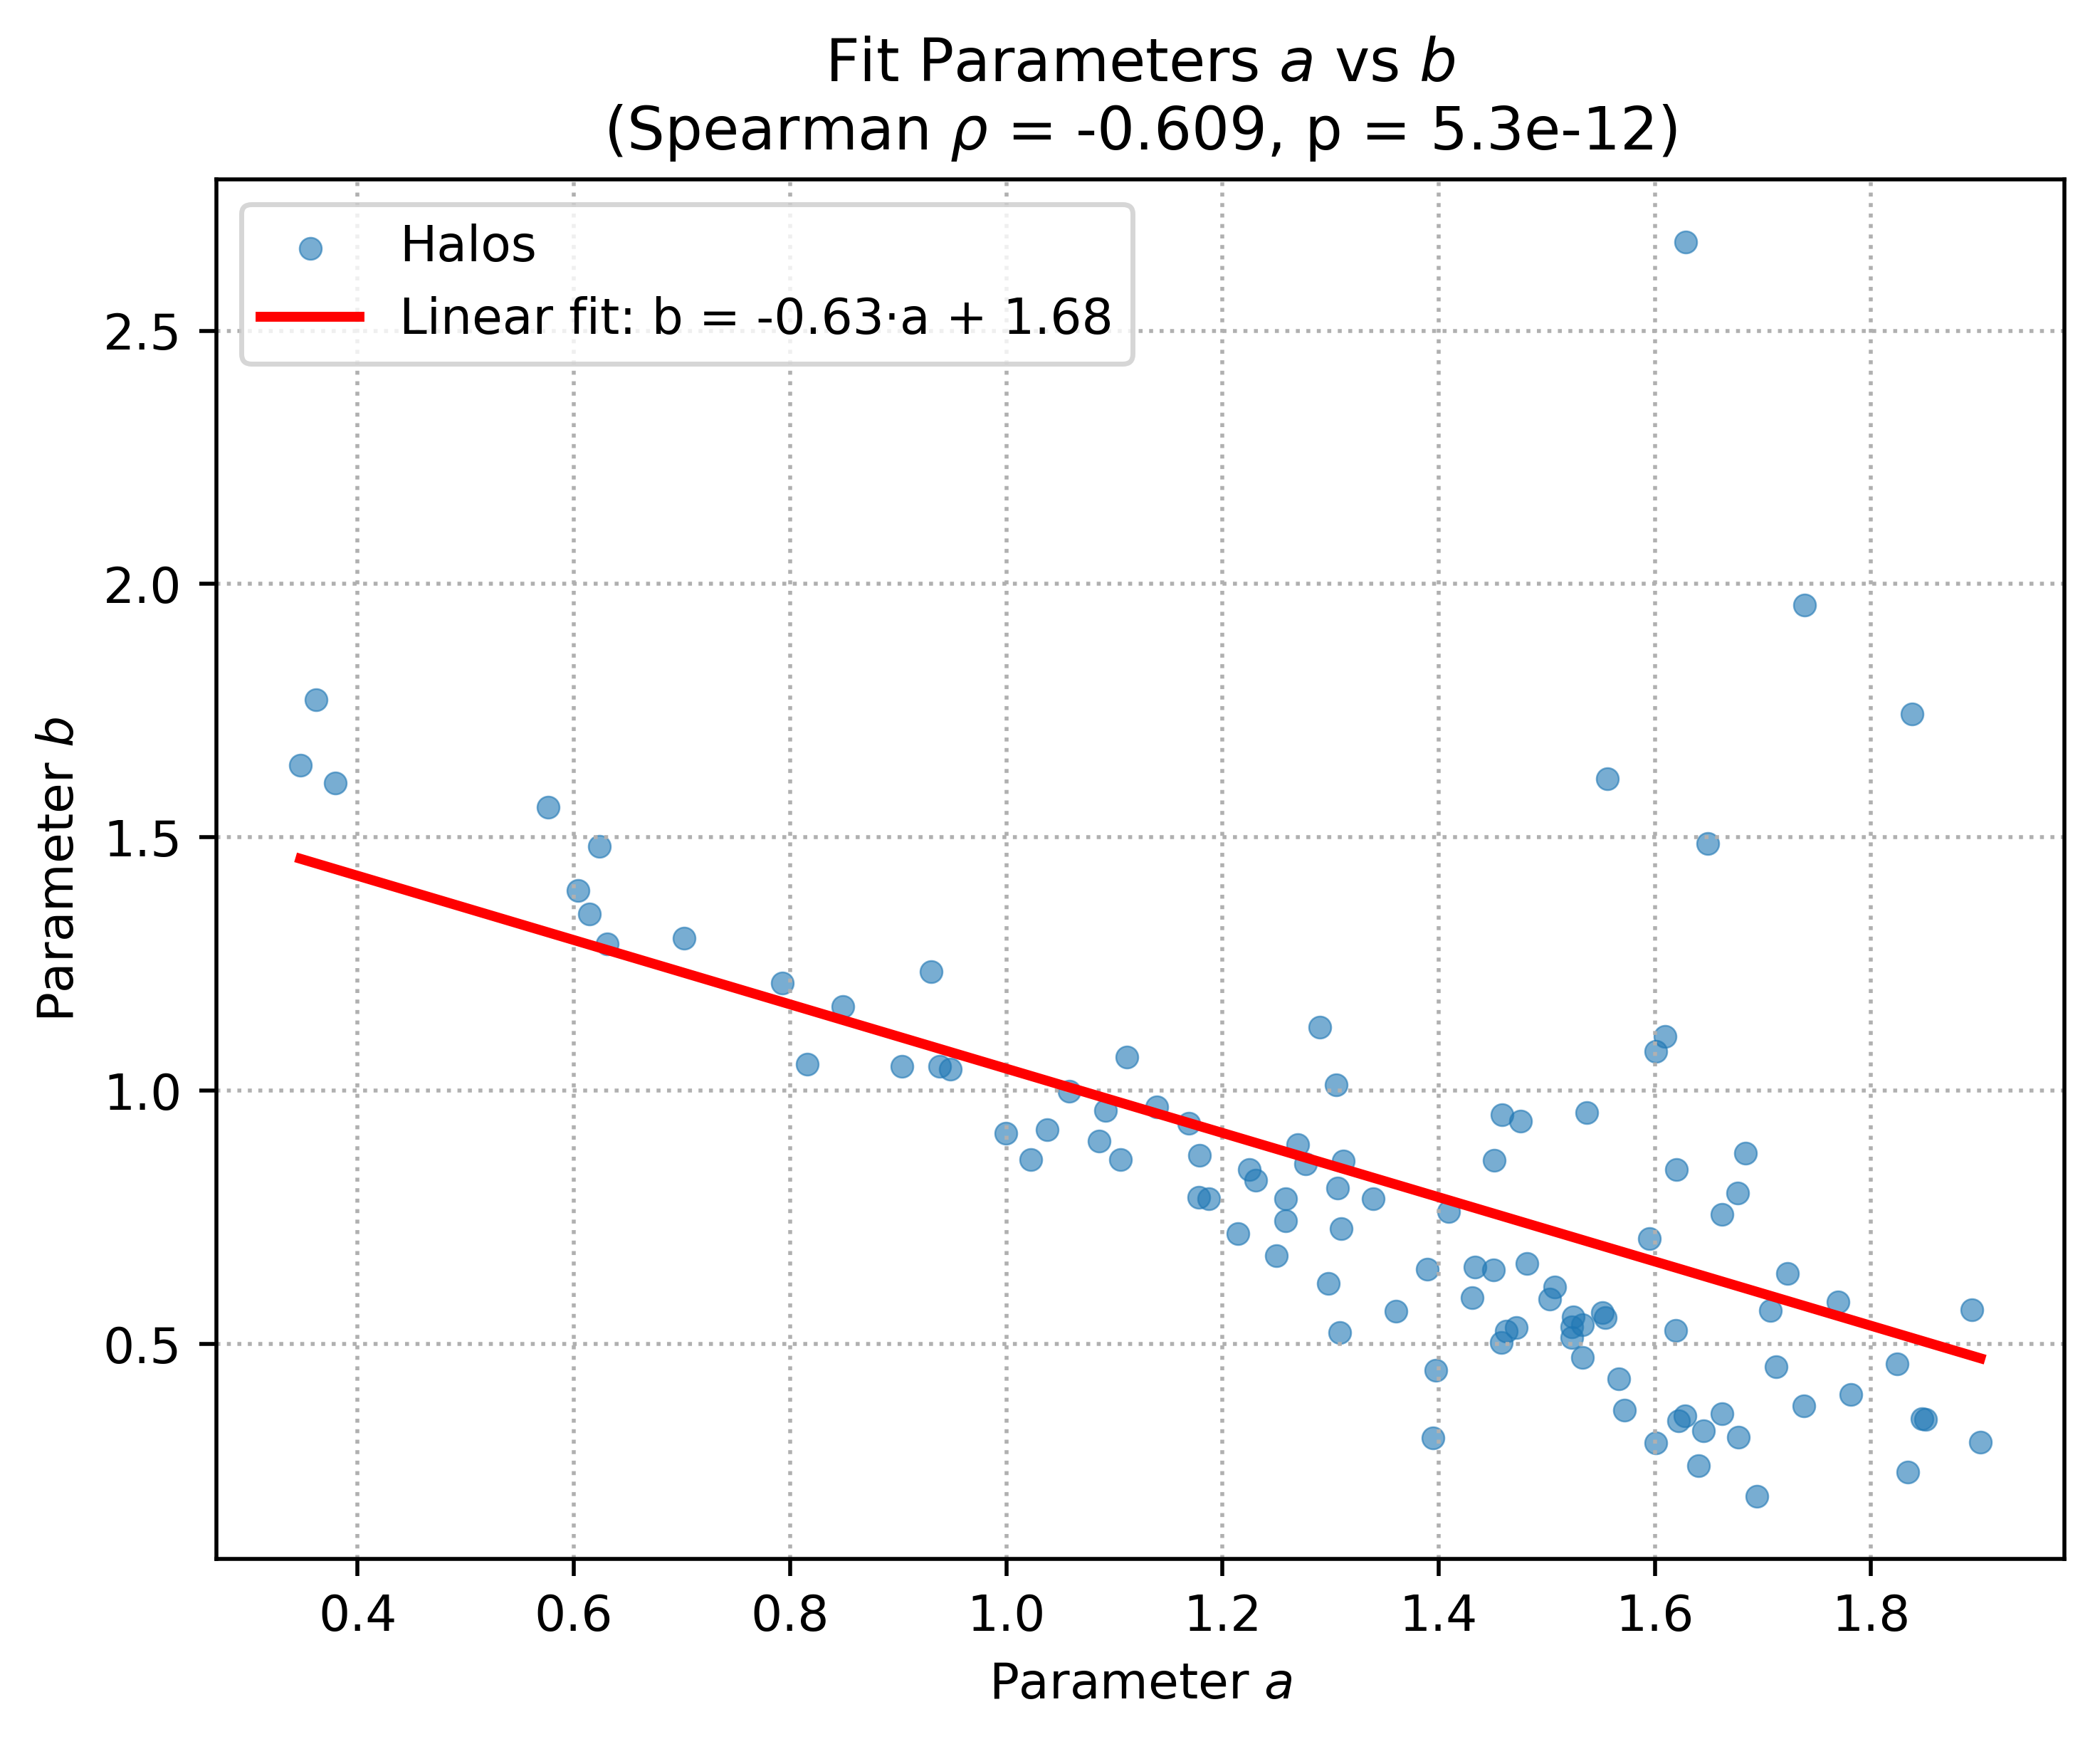

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, linregress
import numpy as np

def plot_ab_distribution_with_fit(df_all_errors, trim_quantiles=(0.01, 0.99)):
    a_raw = df_all_errors["a"].values
    b_raw = df_all_errors["b"].values

    a_min, a_max = np.nanquantile(a_raw, trim_quantiles)
    b_min, b_max = np.nanquantile(b_raw, trim_quantiles)
    mask = (a_raw >= a_min) & (a_raw <= a_max) & (b_raw >= b_min) & (b_raw <= b_max)

    a = a_raw[mask]
    b = b_raw[mask]

    # Spearman
    rho, pval = spearmanr(a, b)

    # Linear regression
    slope, intercept, r_value, _, _ = linregress(a, b)
    line_x = np.linspace(a.min(), a.max(), 100)
    line_y = slope * line_x + intercept

    # Plot
    plt.figure(figsize=(6, 5), dpi=500)
    sns.scatterplot(x=a, y=b, s=20, alpha=0.6, edgecolor=None, label="Halos")
    plt.plot(line_x, line_y, color="red", lw=2, label=f"Linear fit: b = {slope:.2f}·a + {intercept:.2f}")
    plt.xlabel("Parameter $a$")
    plt.ylabel("Parameter $b$")
    plt.title("Fit Parameters $a$ vs $b$\n(Spearman $\\rho$ = {:.3f}, p = {:.1e})".format(rho, pval))
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ab_distribution_with_fit(df_all_errors, trim_quantiles=(0.25, 0.85))

  Sample size  = 224
  ρ = 0.4098, p = 1.75e-10


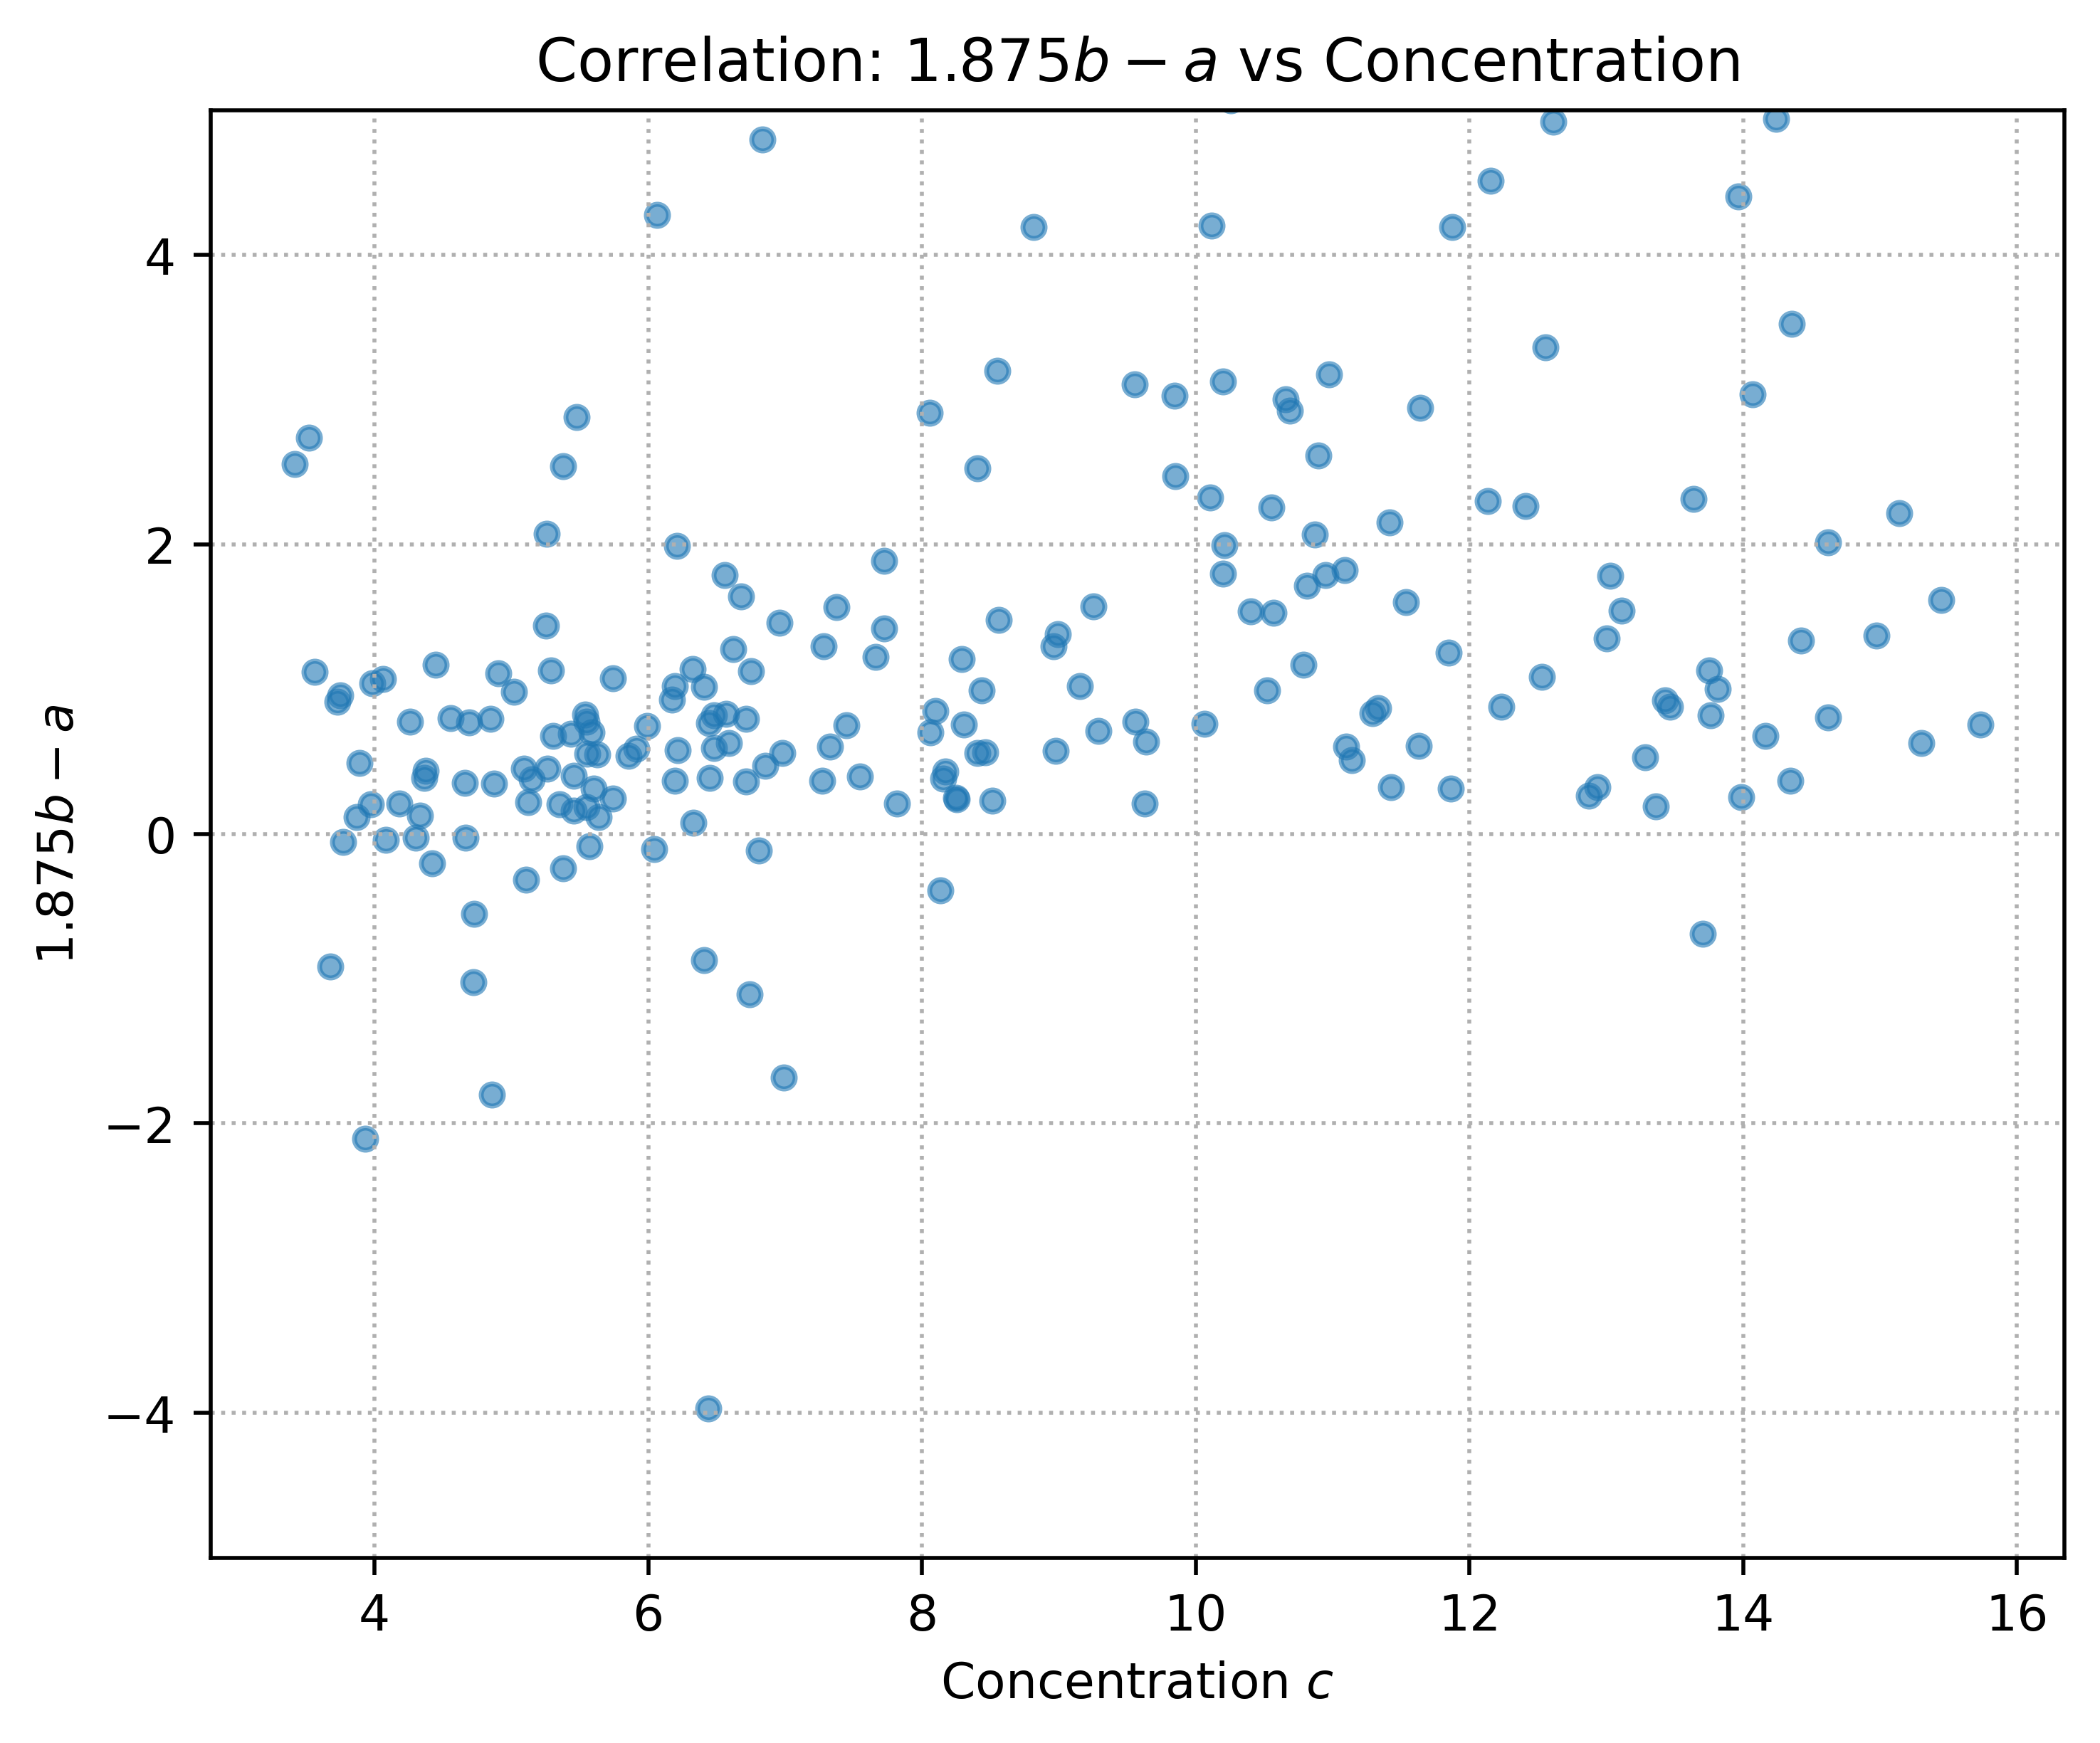

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from glob import glob

def gamma_model(r, a, b):
    return -(2 + a * r) / (1 + b * r)

def compute_params_and_concentration(base_dir, suite_names):
    all_data = []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        conc_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        df_conc = pd.read_csv(conc_path)
        df_conc["halo_id"] = df_conc["halo_id"].astype(str).str.zfill(3)

        for f in sorted(glob(os.path.join(slope_dir, "halo_*.csv"))):
            halo_id = os.path.basename(f).split("_")[1].split(".")[0]
            df = pd.read_csv(f)
            r = df["r_scaled"].values
            slope = df["slope_Q_r"].values
            mask = (r >= 0.01) & (r <= 1.0) & np.isfinite(slope)
            r_fit = r[mask]
            y_fit = slope[mask]
            if len(r_fit) < 5:
                continue
            try:
                popt, _ = curve_fit(gamma_model, r_fit, y_fit, p0=[1.0, 1.0])
                a, b = popt
                c_row = df_conc[df_conc["halo_id"] == halo_id]
                if not c_row.empty:
                    cvir = c_row["cvir"].values[0]
                    all_data.append({
                        "suite": suite,
                        "halo_id": halo_id,
                        "a": a,
                        "b": b,
                        "cvir": cvir,
                        "slope_bias": 1.875 * b - a
                    })
            except RuntimeError:
                continue

    return pd.DataFrame(all_data)

def analyze_slope_bias_vs_concentration(base_dir, suite_names, trim=(0.01, 0.99)):
    df = compute_params_and_concentration(base_dir, suite_names)
    if df.empty:
        print("❌ No valid halo fits found.")
        return

    # Trim
    bias = df["slope_bias"].values
    cvir = df["cvir"].values
    qmin_bias, qmax_bias = np.quantile(bias, trim)
    qmin_c, qmax_c = np.quantile(cvir, trim)
    mask = (bias >= qmin_bias) & (bias <= qmax_bias) & (cvir >= qmin_c) & (cvir <= qmax_c)

    x = df["cvir"].values[mask]
    y = df["slope_bias"].values[mask]

    # Spearman
    rho, pval = spearmanr(x, y)

    print(f"  Sample size  = {len(x)}")
    print(f"  ρ = {rho:.4f}, p = {pval:.2e}")

    # Plot
    plt.figure(figsize=(6, 5), dpi=500)
    plt.scatter(x, y, s=20, alpha=0.6)
    plt.ylim(-5, 5)
    plt.xlabel("Concentration $c$")
    plt.ylabel(r"$1.875 b - a$")
    plt.title("Correlation: $1.875 b - a$ vs Concentration")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

    return df

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
df_result = analyze_slope_bias_vs_concentration(base_dir, suite_names)